# Sentiment and Plot in Novels

DS 5001 Text as Data

**Purpose:** Use a Python variant of [Matt Jockers' Syuzhet R library](https://cran.r-project.org/web/packages/syuzhet/vignettes/syuzhet-vignette.html) to explore ways to measure sentiment and track plot in all the novels.

# Set Up

## Config

In [1]:
sent_col = 'bing' # Produces good clustering
bag = 'SENTS'

In [2]:
# sent_col = 'syu' 

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
lib_file = f'{data_home}/syuzhet/combo-LIB.csv' # Also created in previous notebook

## Import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.fft as fft

In [6]:
sns.set()

# Get the Books

Grab a subset of books to explore.

In [7]:
M = {bag:pd.read_pickle(f"{data_home}/syuzhet/M_{bag}.pickle") for bag in "SENTS PARAS CHAPS".split()}

In [8]:
M['SENTS']

nrc_sentiment  bing_sentiment  \
book_id chap_id para_num sent_num                                  
105     1       1        0              0.000000       -0.454545   
                         1              0.000000        0.000000   
                2        0              0.000000        0.000000   
                3        0              1.000000        0.000000   
                         1              0.000000       -1.000000   
...                                          ...             ...   
usher   1       47       0             -1.000000       -1.000000   
                         1             -0.333333       -1.000000   
                         2             -1.000000       -1.000000   
                         3              1.000000        1.000000   
                         4             -0.200000       -0.200000   

                                   syu_sentiment  gi_sentiment  
book_id chap_id para_num sent_num                               
105     1       1        0             -0.120588      0.333333  
                         1              0.000000      0.000000  
                2        0              0.000000      0.000000  
                3        0              0.600000      0.000000  
                         1             -0.500000      0.000000  
...                                          ...           ...  
usher   1       47       0             -0.900000     -1.000000  
                         1             -0.050000     -1.000000  
                         2             -0.462500      0.000000  
                         3              0.425000      1.000000  
                         4             -0.164286      0.200000  

[177981 rows x 4 columns]

In [9]:
LIB = pd.read_csv(lib_file).set_index('book_id')

In [10]:
LIB.head(10)

author_id            title  corpus
book_id                                           
secretadversary  christie  secretadversary  novels
styles           christie           styles  novels
moonstone         collins        moonstone  novels
adventures          doyle       adventures  novels
baskervilles        doyle     baskervilles  novels
scarlet             doyle          scarlet  novels
signoffour          doyle       signoffour  novels
marieroget            poe       marieroget  novels
ruemorgue             poe        ruemorgue  novels
northangerabbey    austen  northangerabbey  novels

# Define Classes

**Jockers' original FFT function params**

<table>
    <tr><td>raw_values</td><td>the raw sentiment values calculated for each sentence</td></tr>
    <tr><td>low_pass_size</td><td>The number of components to retain in the low pass filtering. Default = 3</td></tr>
    <tr><td>x_reverse_len</td><td>the number of values to return. Default = 100</td></tr>
    <tr><td>padding_factor</td><td>the amount of zero values to pad raw_values with, as a factor of the size of raw_values. Default = 2.</td></tr>
    <tr><td>scale_vals</td><td>Logical determines whether or not to normalize the values using the scale function Default = FALSE. If TRUE, values will be scaled by subtracting the means and scaled by dividing by their standard deviations. See ?scale</td></tr>
    <tr><td>scale_range</td><td>Logical determines whether or not to scale the values from -1 to +1. Default = FALSE. If set to TRUE, the lowest value in the vector will be set to -1 and the highest values set to +1 and all the values scaled accordingly in between.</td></tr>
</table>    

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [11]:
class Transforms:
    
    def FFT(raw_values, 
               low_pass_size=3, 
               x_reverse_len=100,  
               padding_factor=2, 
               scale_values=False, 
               scale_range=False):

        if low_pass_size > len(raw_values):
            sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

        raw_values_len = len(raw_values)
        padding_len = raw_values_len * padding_factor

        # Add padding, then fft
        values_fft = fft.fft(raw_values, padding_len)
        low_pass_size = low_pass_size * (1 + padding_factor)
        keepers = values_fft[:low_pass_size]

        # Preserve frequency domain structure
        modified_spectrum = list(keepers) \
            + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
            + list(reversed(np.conj(keepers[1:(len(keepers))])))

        # Strip padding
        inverse_values = fft.ifft(modified_spectrum)
        inverse_values = inverse_values[:x_reverse_len]

        transformed_values = np.real(tuple(inverse_values))
        return transformed_values        
        
    def DCT(raw_values, 
                  low_pass_size=5, 
                  x_reverse_len=100,
                  dct_type=3):
        
        if low_pass_size > len(raw_values):
            raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
        
        values_dct = fft.dct(raw_values, type = dct_type) # 2 or 3 works well
        
        keepers = values_dct[:low_pass_size]
        
        padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
        
        dct_out = fft.idct(padded_keepers)
        
        return dct_out

In [12]:
class SyuzhetBook:
    
    def __init__(self, sent_vec, book_title):
        self.S = sent_vec
        self.book_title = book_title
        
    def plot_raw(self):

        plot_cfg = dict(
            figsize=(25, 5), 
            legend=False, 
            fontsize=16)
        
        self.S.plot(**plot_cfg)
        
    def plot_smooth(self, 
                 method='DCT', 
                 low_pass_size=6, 
                 x_reverse_len=100):

        plot_cfg = dict(
            figsize = (25, 5), 
            legend = False, 
            fontsize = 16,
            title = f"{self.book_title} {method}"
        )

        if method == "DCT":
            X = Transforms.DCT(self.S.values, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len)
        elif method == "FFT":
            X = Transforms.FFT(self.S.values, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len, padding_factor = 1)

        # Scale Range
        X = (X - X.mean()) / X.std()

        pd.Series(X).plot(**plot_cfg);
        
    def plot_rolling(self, 
                         win_type='cosine', 
                         win_div=3,
                         norm=None):
        
        window = round(self.S.shape[0]/win_div)
        plot_title = self.book_title + f'  (rolling; div={win_div}, w={window})'
        self.S.rolling(window, win_type=win_type).mean().plot(figsize=(25,5), title=plot_title)
        # ax.set_title(plot_title, fontsize=20)


We define a helper function to convert our data into sentiment vectors.

In [13]:
def get_sent_vec(book_id, bag=bag, src=sent_col):
    global M, LIB
    book_title = LIB.loc[str(book_id)].title        
    return M[bag].loc[str(book_id), f"{src}_sentiment"].reset_index(drop=True), book_title

# Explore 

## Persuasion

In [14]:
pg105 = SyuzhetBook(*get_sent_vec(105))

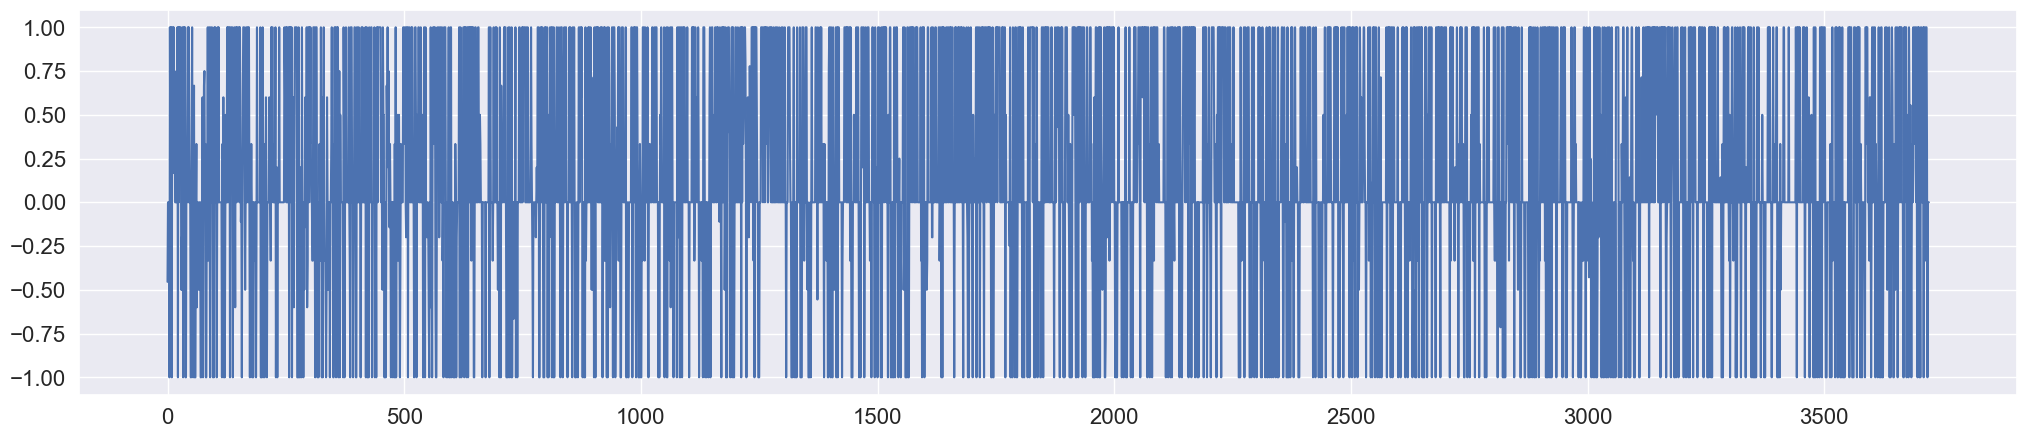

In [15]:
pg105.plot_raw()

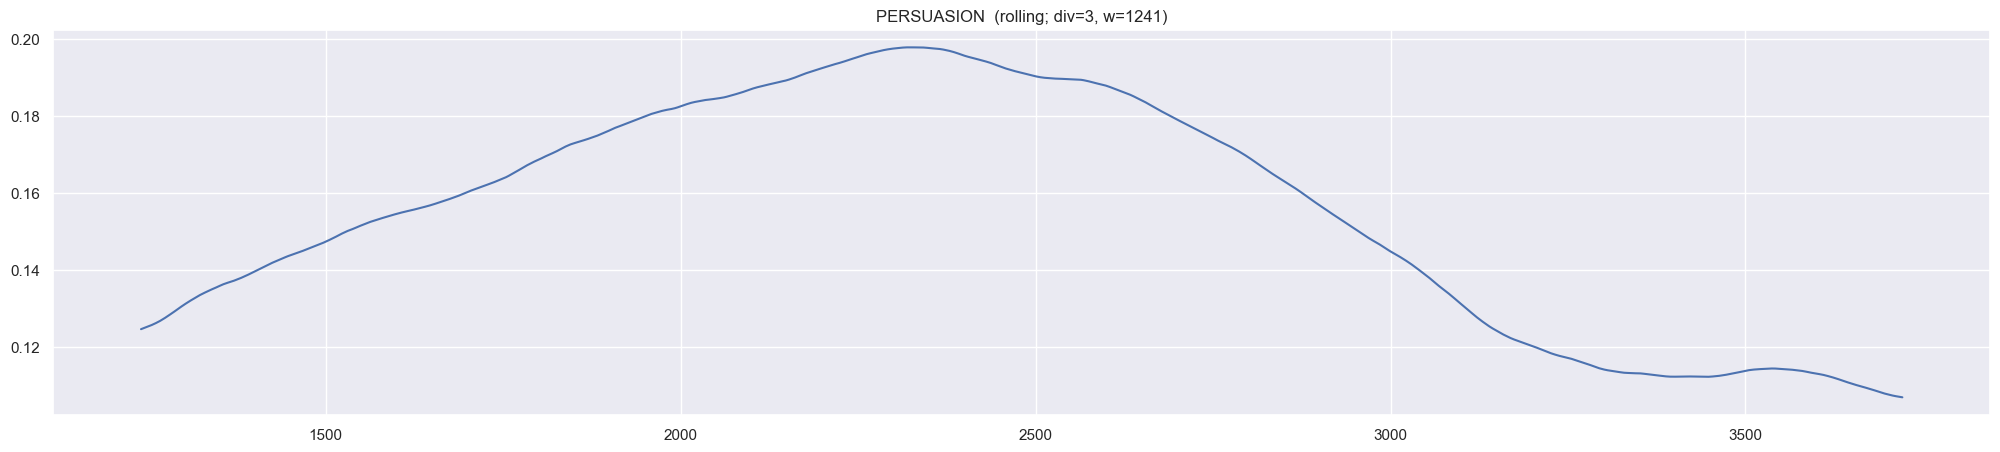

In [16]:
pg105.plot_rolling()

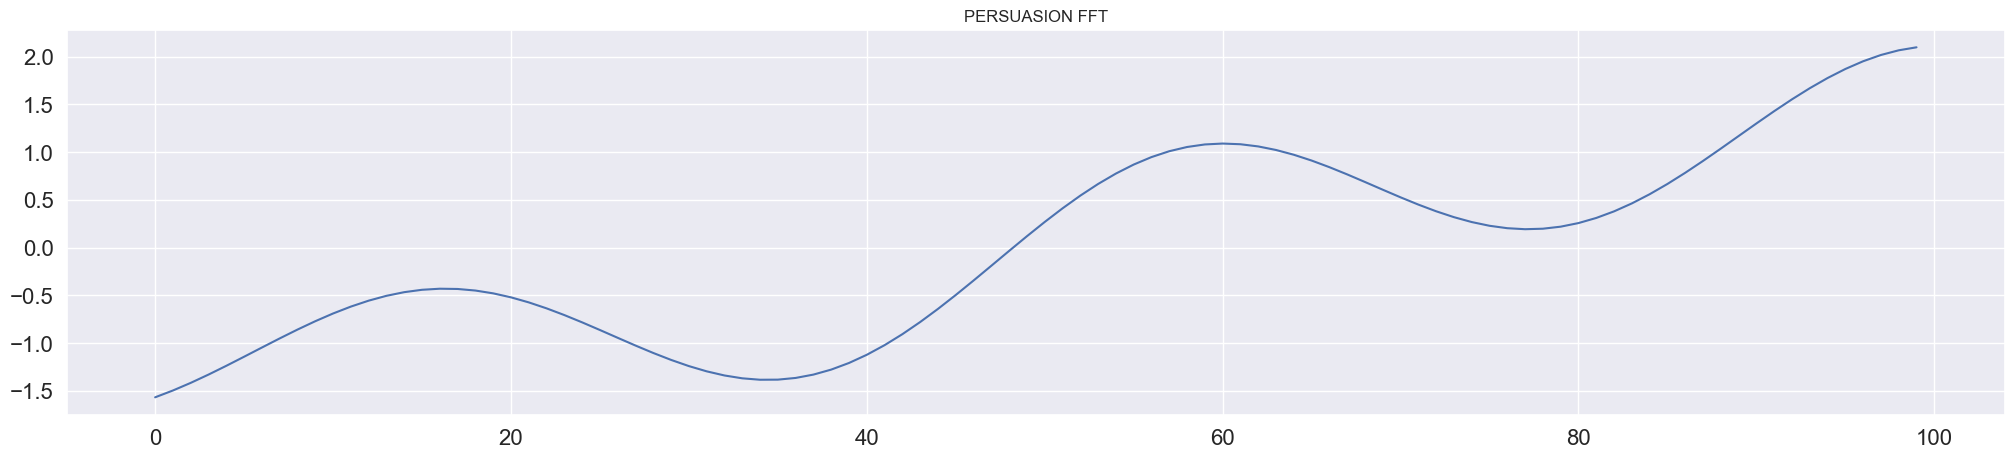

In [17]:
pg105.plot_smooth('FFT', low_pass_size=3)

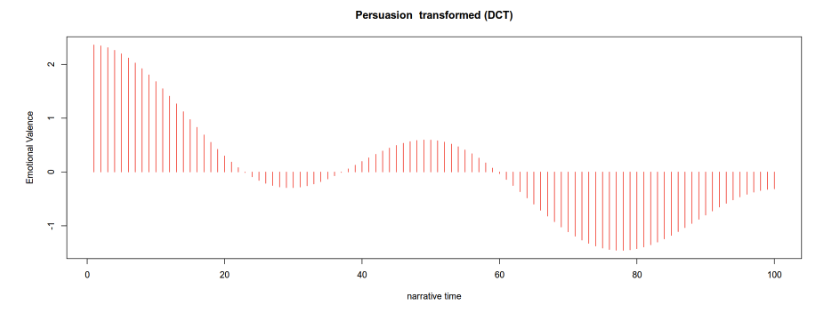

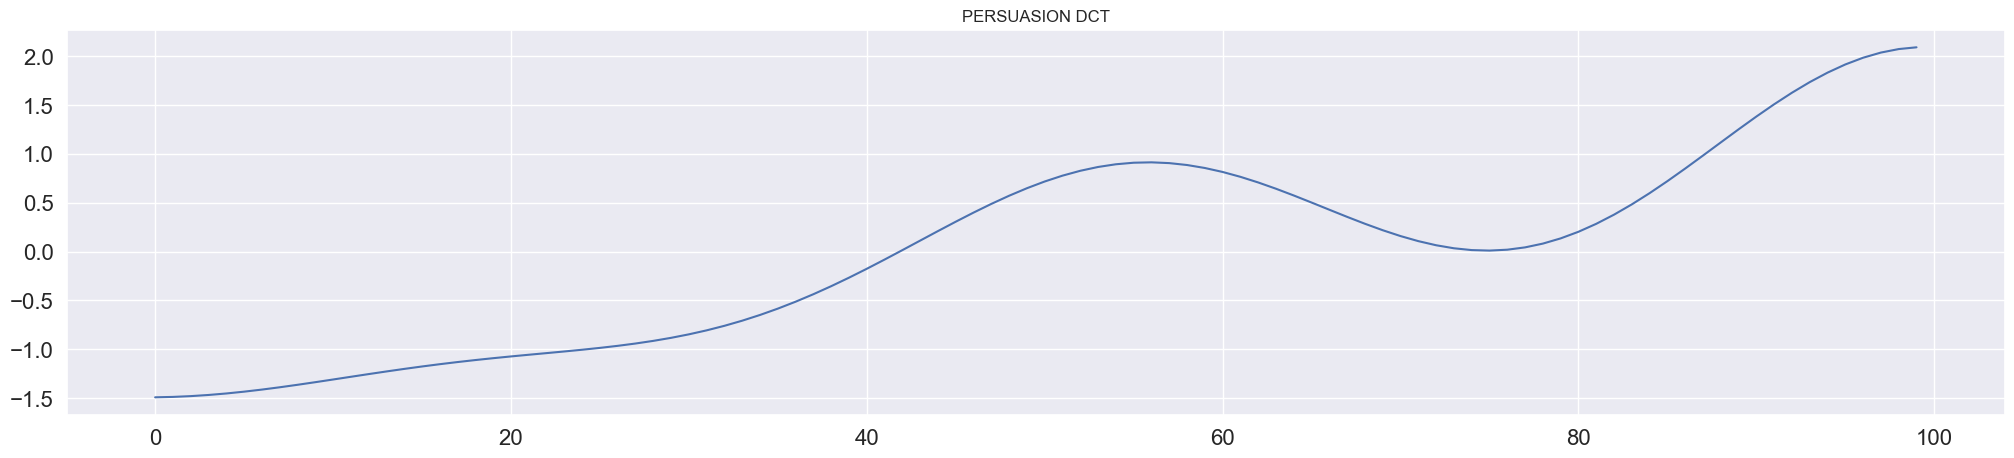

In [18]:
pg105.plot_smooth()

## Moby Dick

In [19]:
pg2701 = SyuzhetBook(*get_sent_vec(2701))

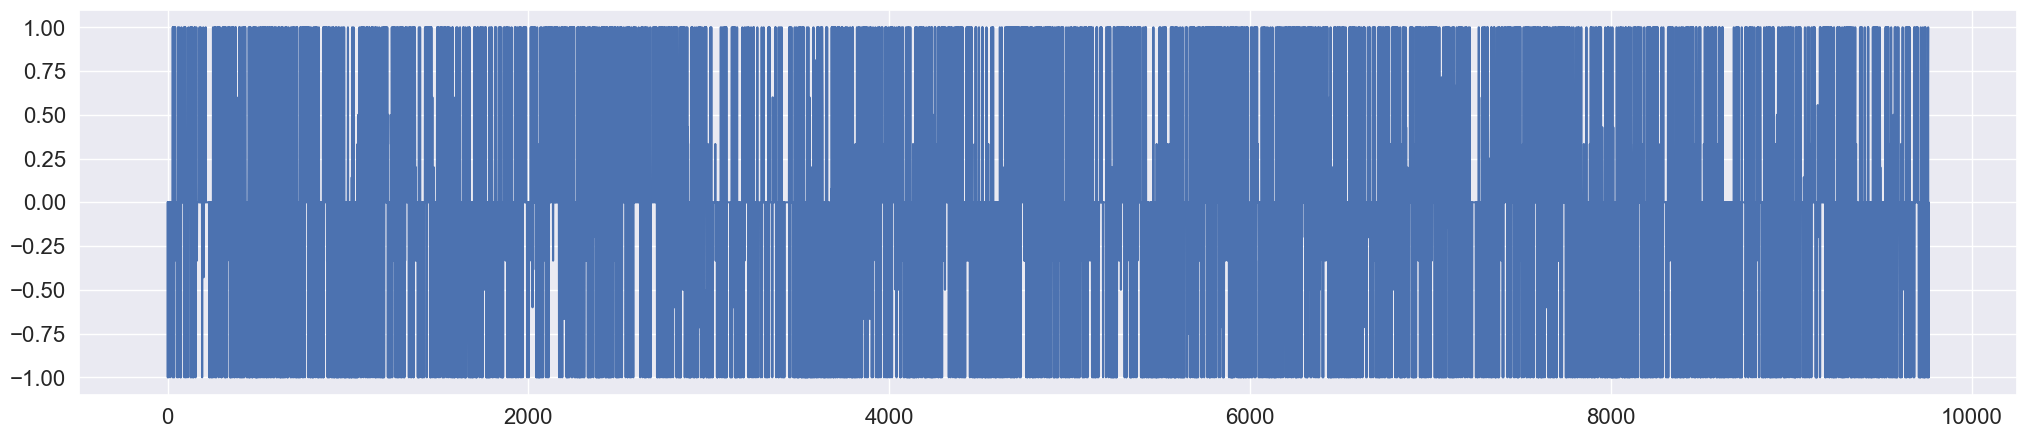

In [20]:
pg2701.plot_raw()

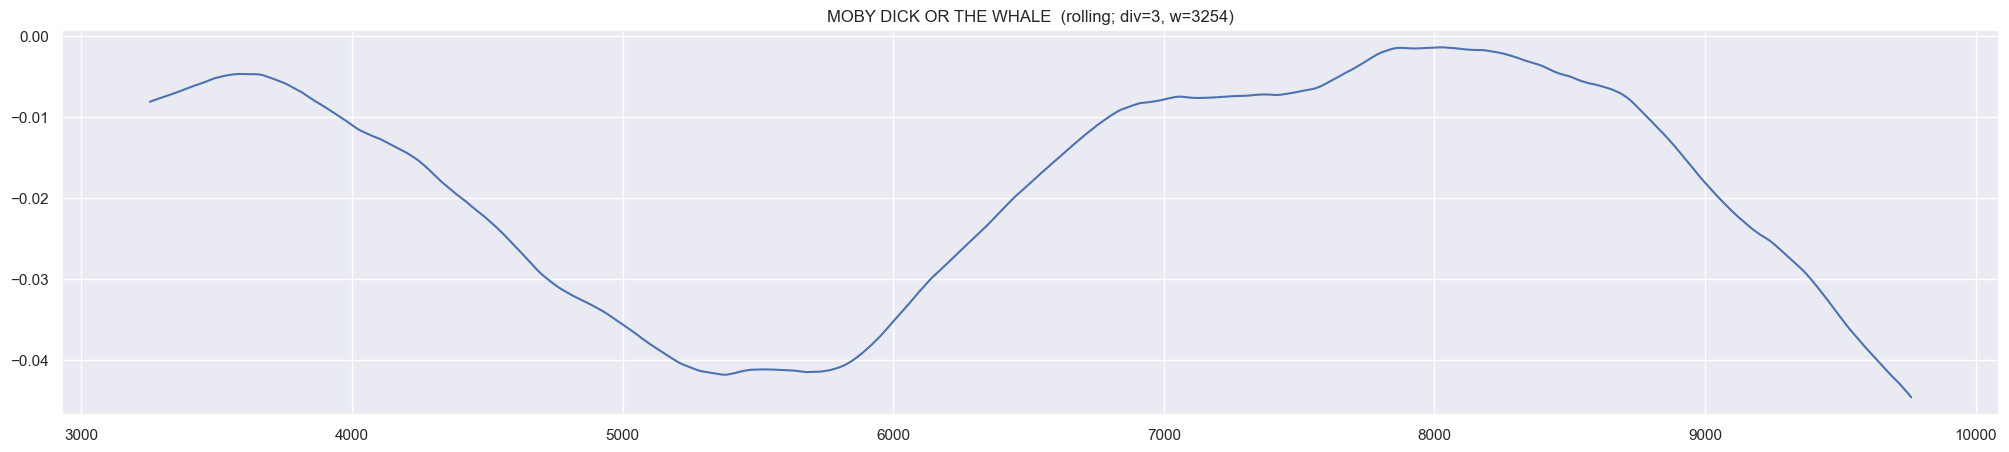

In [21]:
pg2701.plot_rolling()

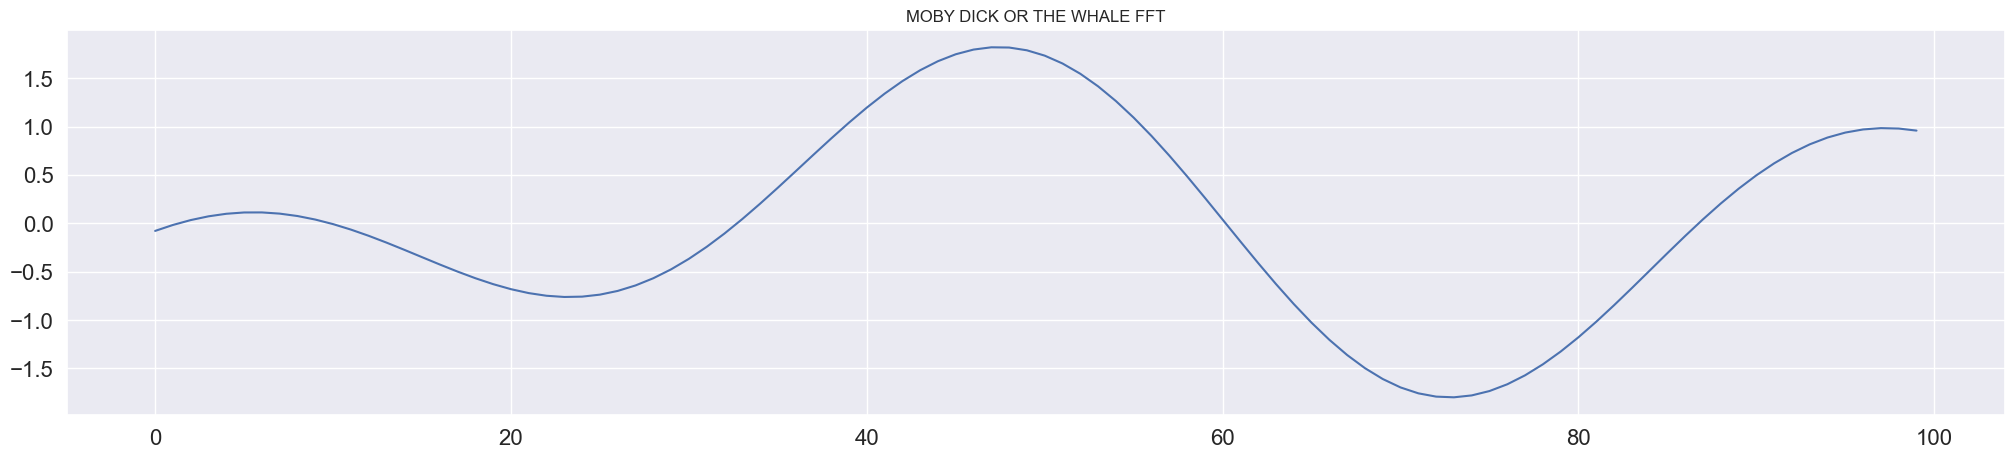

In [22]:
pg2701.plot_smooth('FFT', low_pass_size=3)

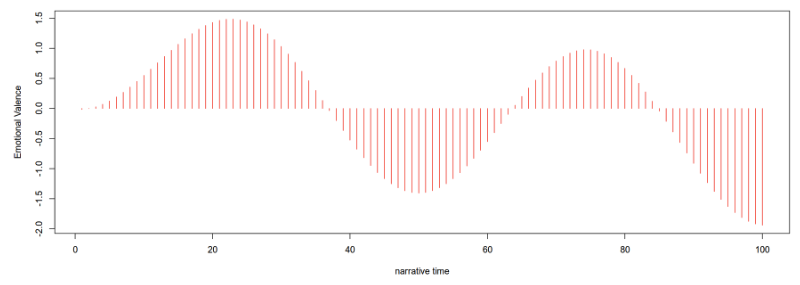

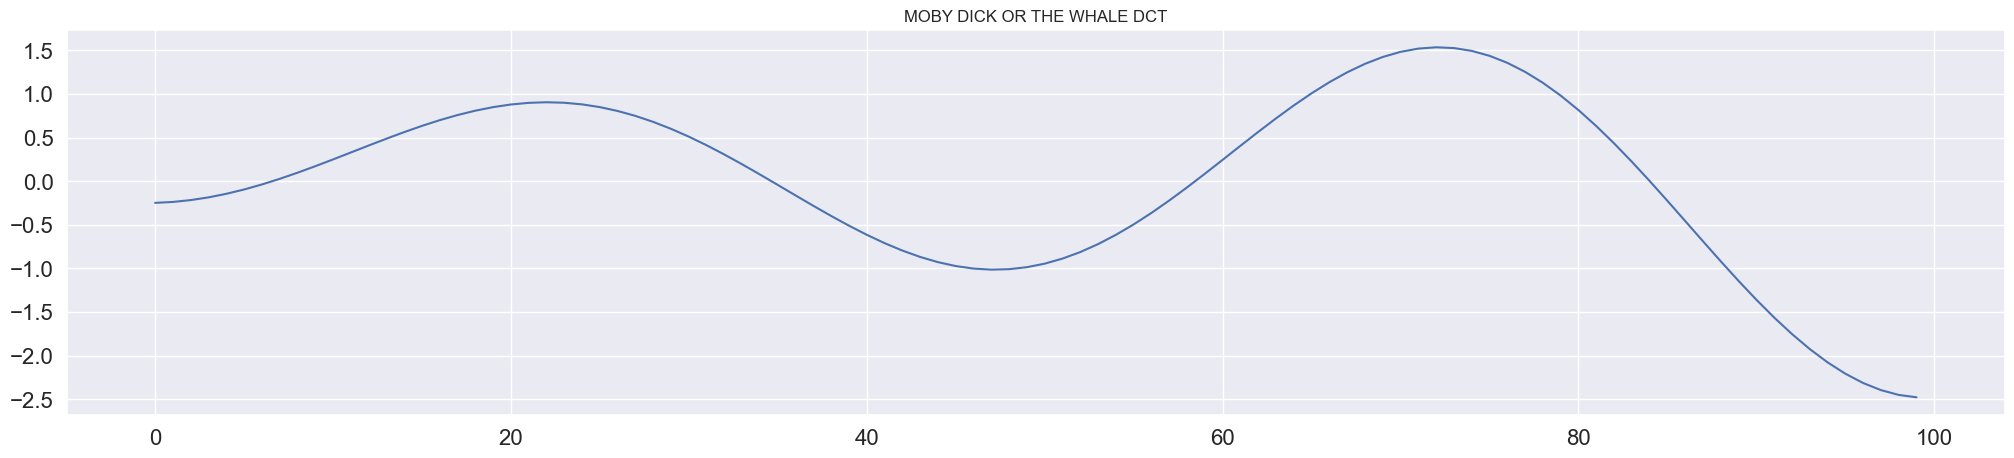

In [23]:
pg2701.plot_smooth()

> Some say the ending of Moby-Dick is simple and deceiving. In the novel, Moby Dick destroys the Pequod, killing everyone but Ishmael. Some say the ending creates a sense of **mystery** for the audience. \
\
Others say the ending is **glorious**, with every detail of the battle clear. Some say the book is open to many interpretations, and is important for introducing the concept of allegory. For example, the relationship between Ahab and Moby Dick could be interpreted as an allegory for the Gold Rush.

## Frankenstein

In [24]:
frankenstein = SyuzhetBook(*get_sent_vec('frankenstein'))

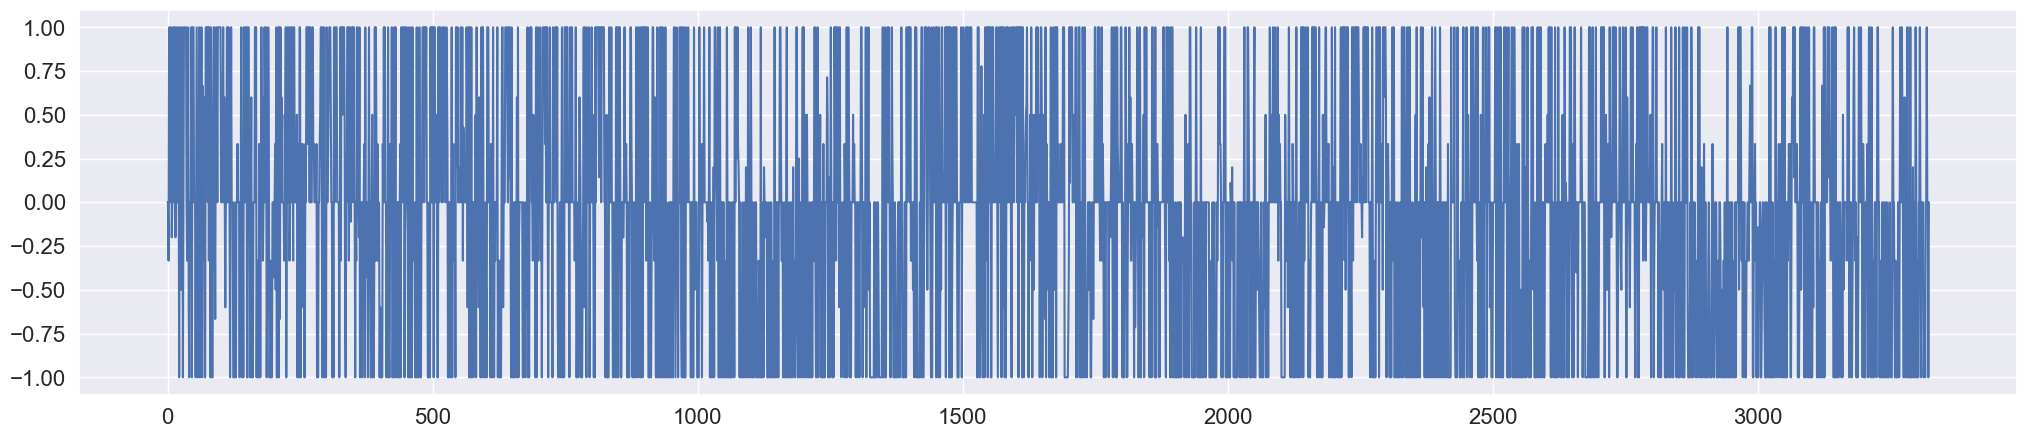

In [25]:
frankenstein.plot_raw()

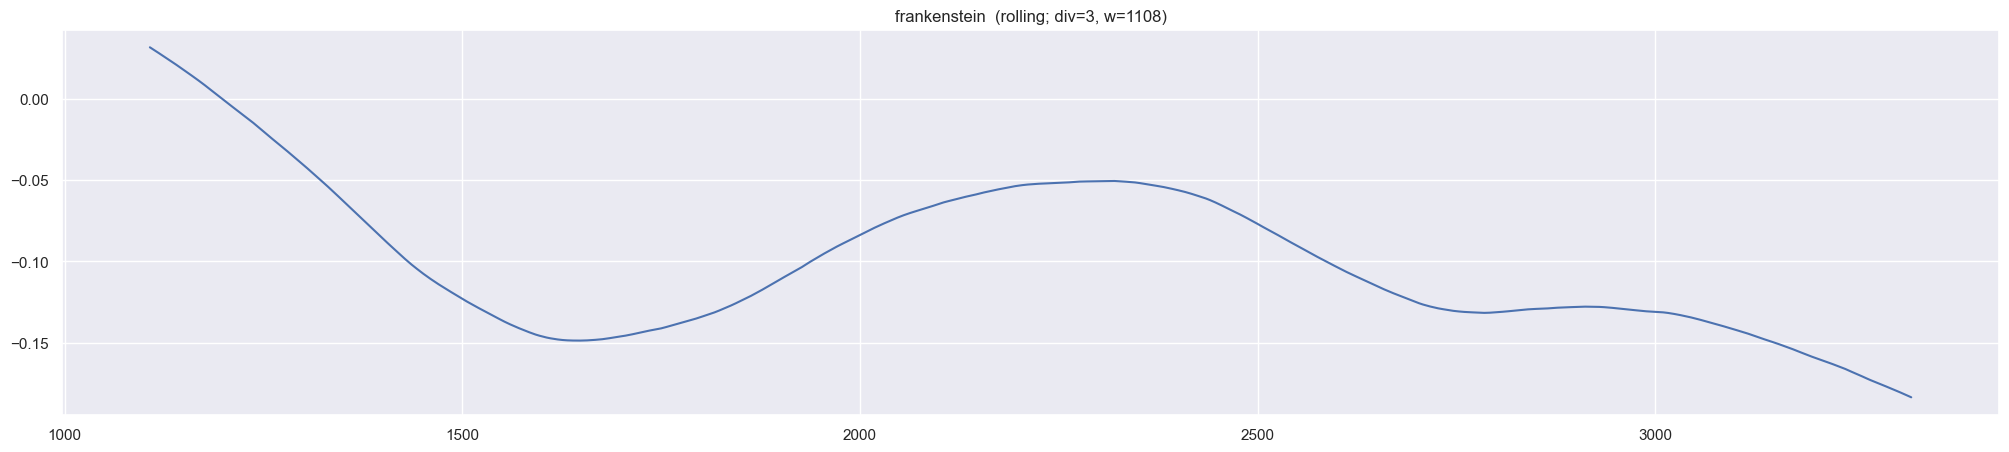

In [26]:
frankenstein.plot_rolling()

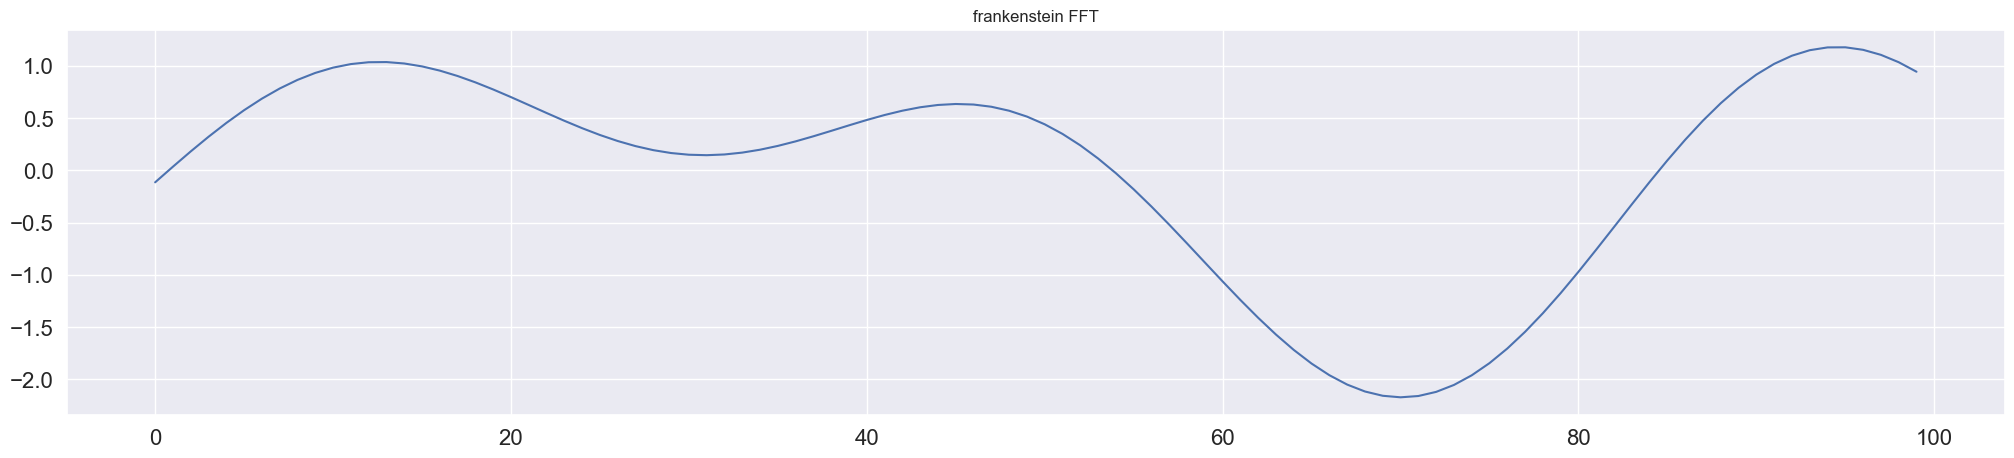

In [27]:
frankenstein.plot_smooth('FFT', low_pass_size=3)

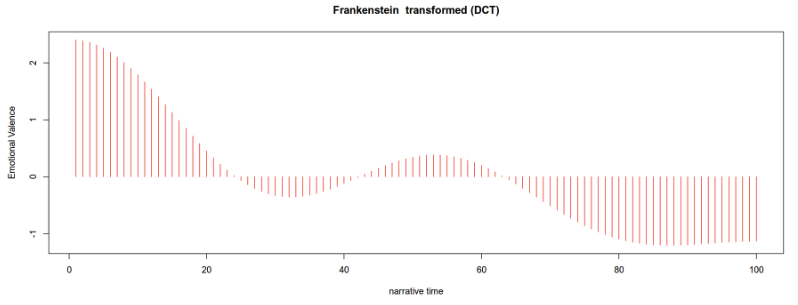

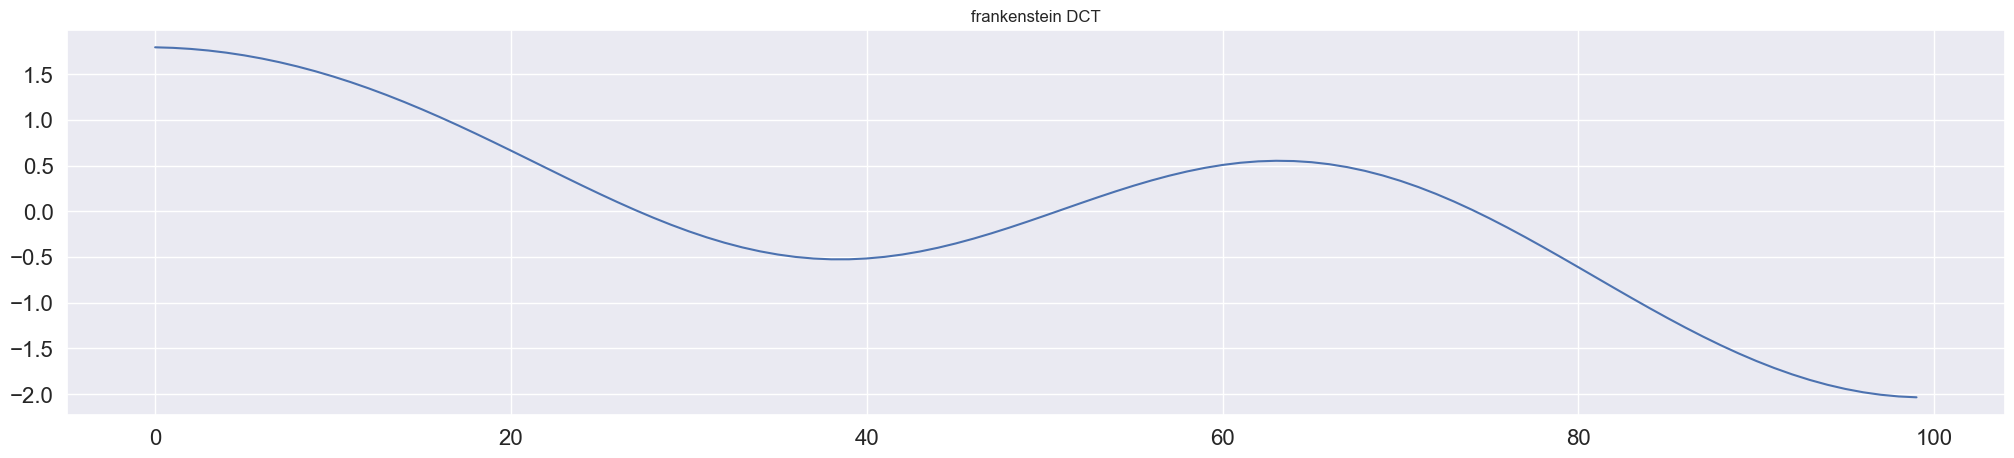

In [28]:
frankenstein.plot_smooth()

## Dracula

In [29]:
dracula = SyuzhetBook(*get_sent_vec('dracula'))

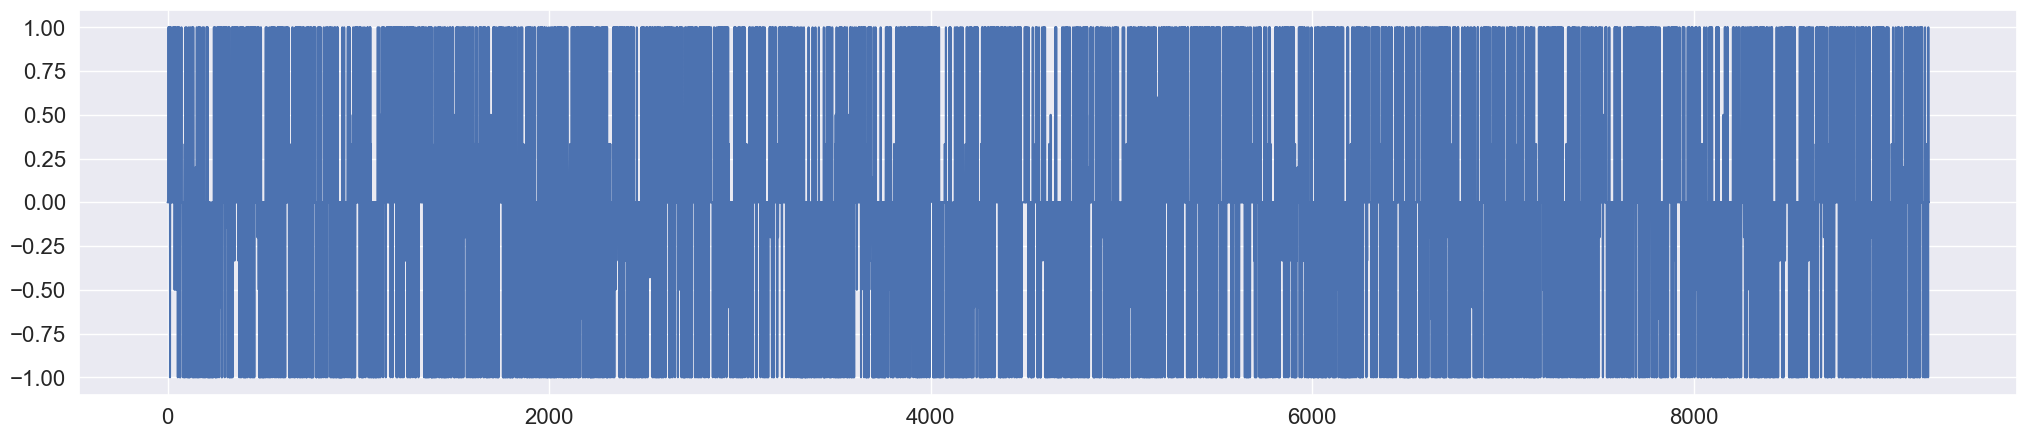

In [30]:
dracula.plot_raw()

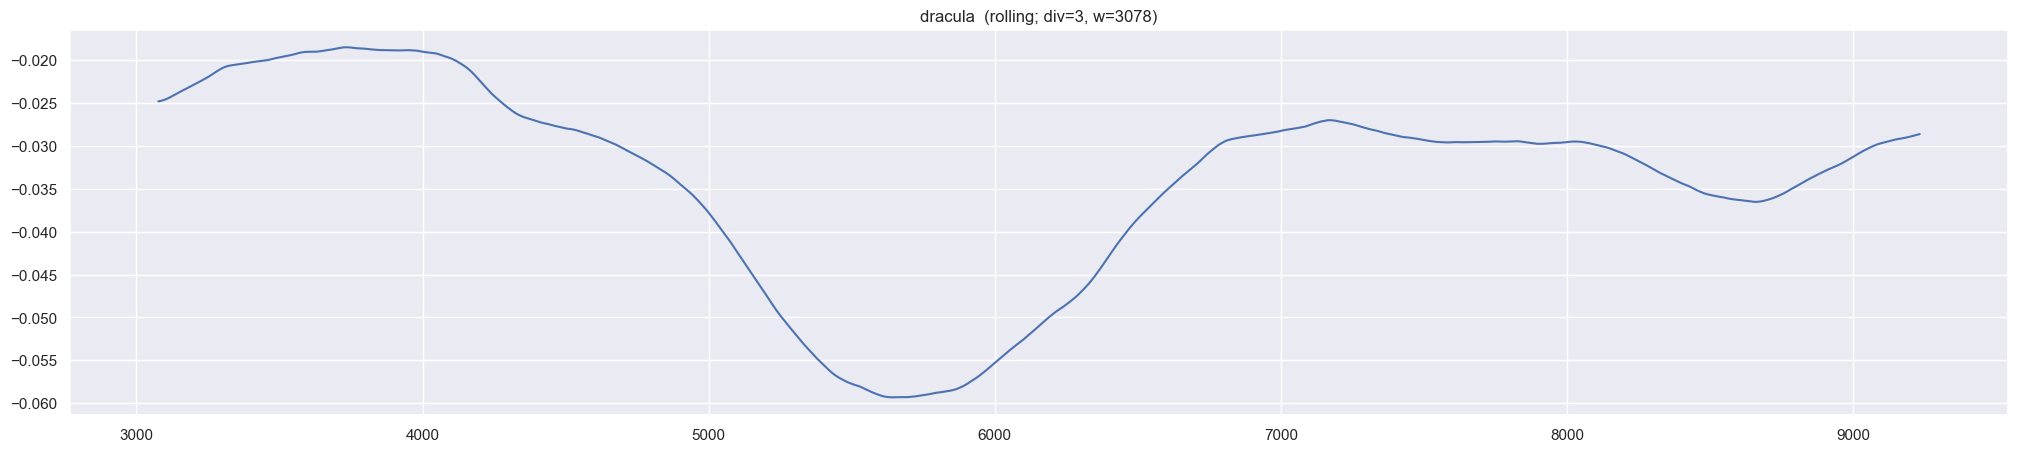

In [31]:
dracula.plot_rolling()

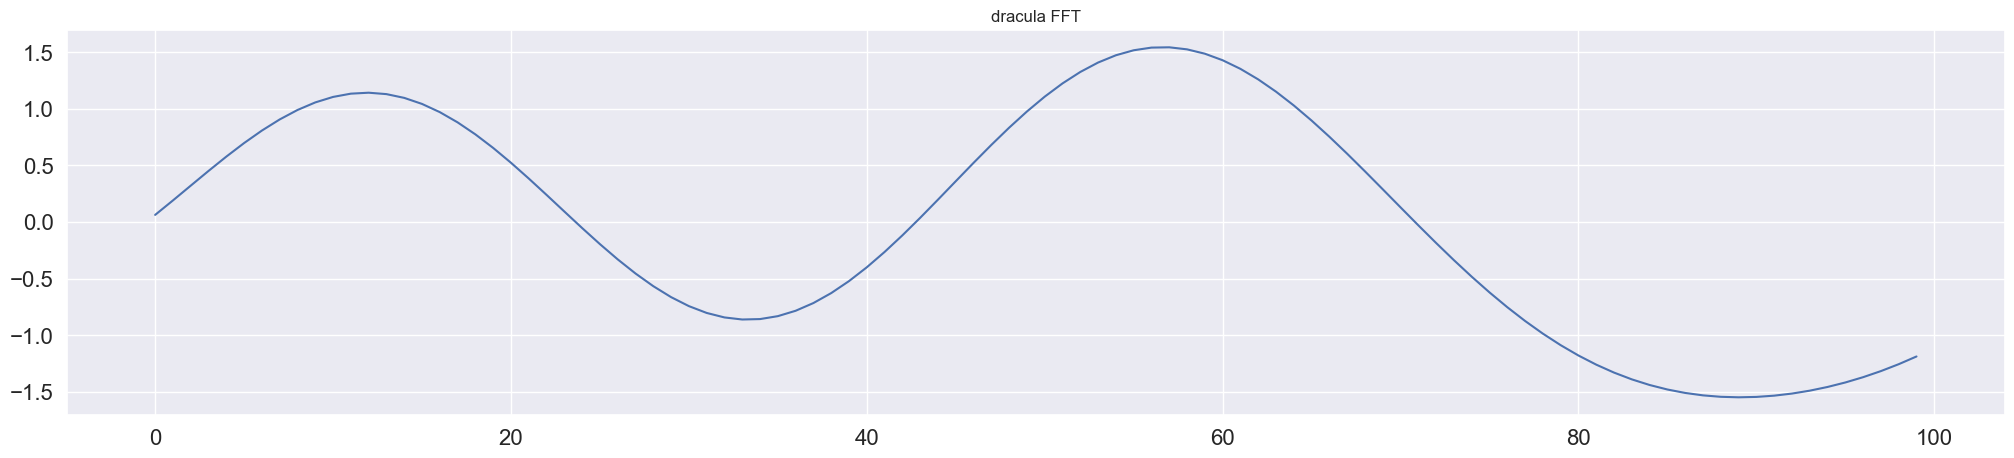

In [32]:
dracula.plot_smooth('FFT', low_pass_size=3)

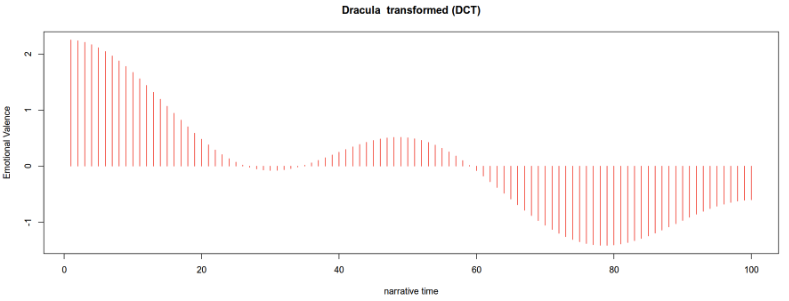

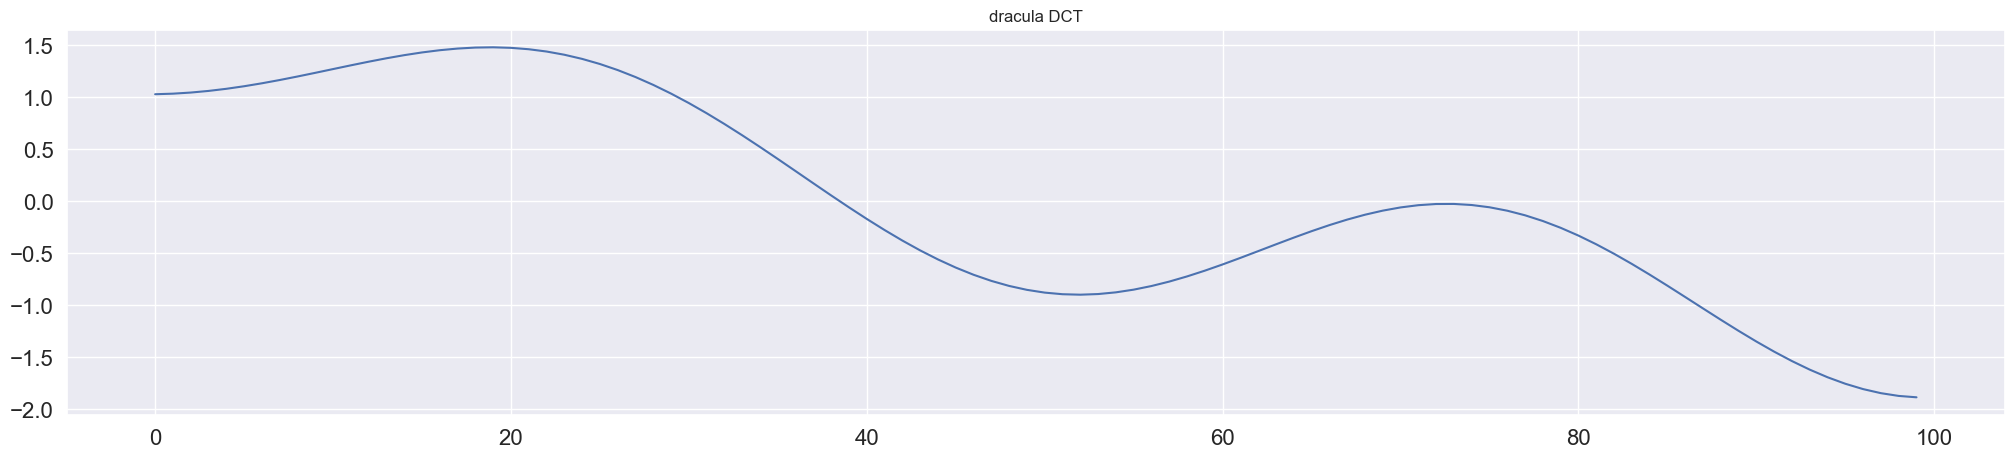

In [33]:
dracula.plot_smooth()

## Pride and Prejudice

In [34]:
pg1342 = SyuzhetBook(*get_sent_vec(1342))

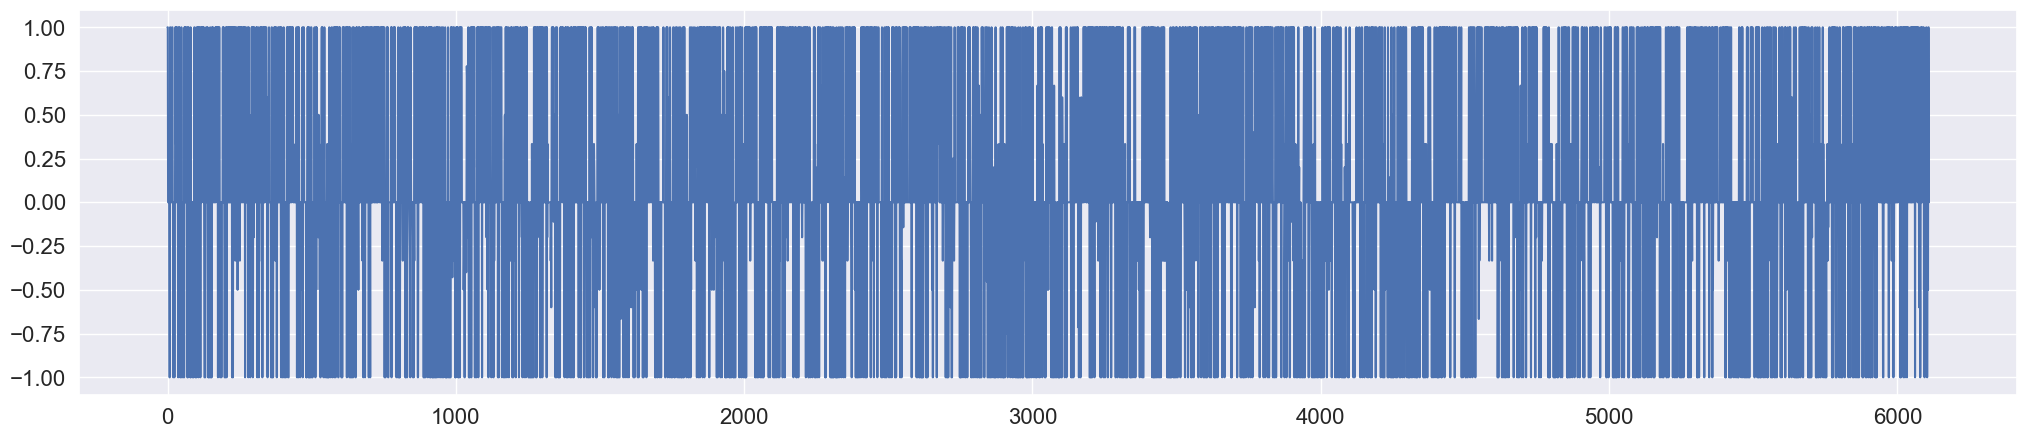

In [35]:
pg1342.plot_raw()

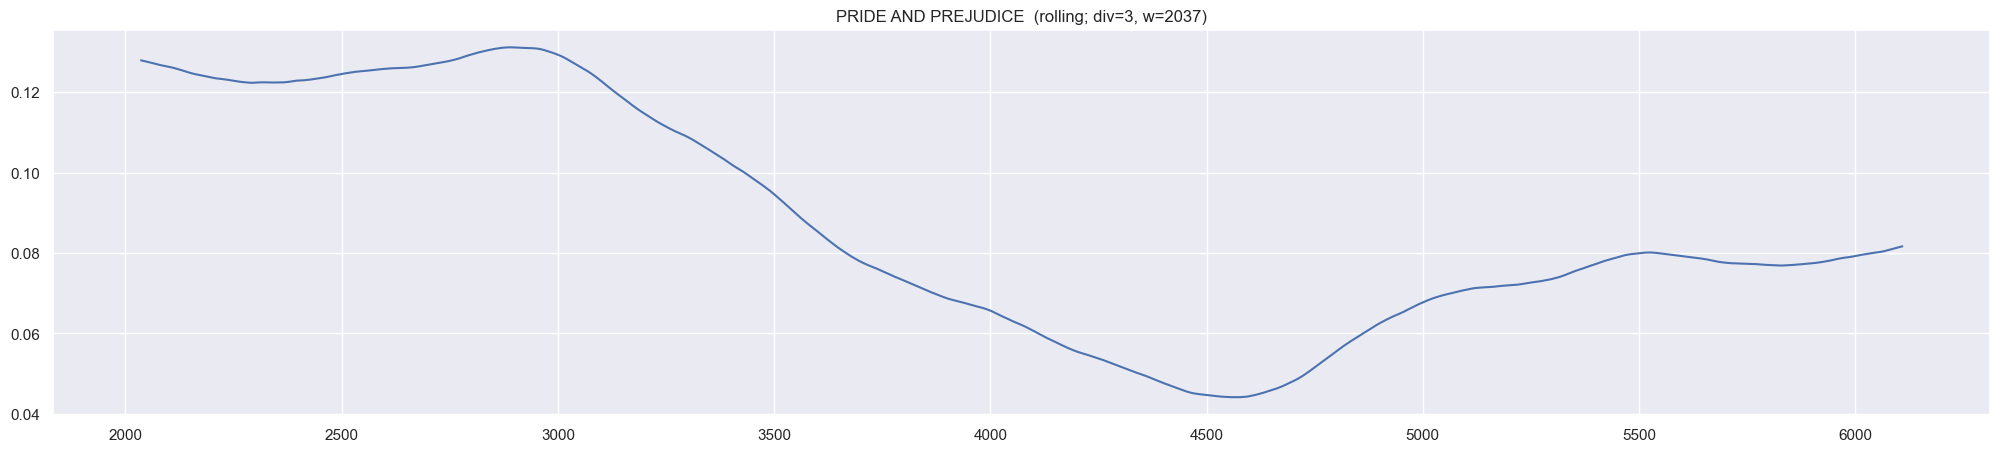

In [36]:
pg1342.plot_rolling()

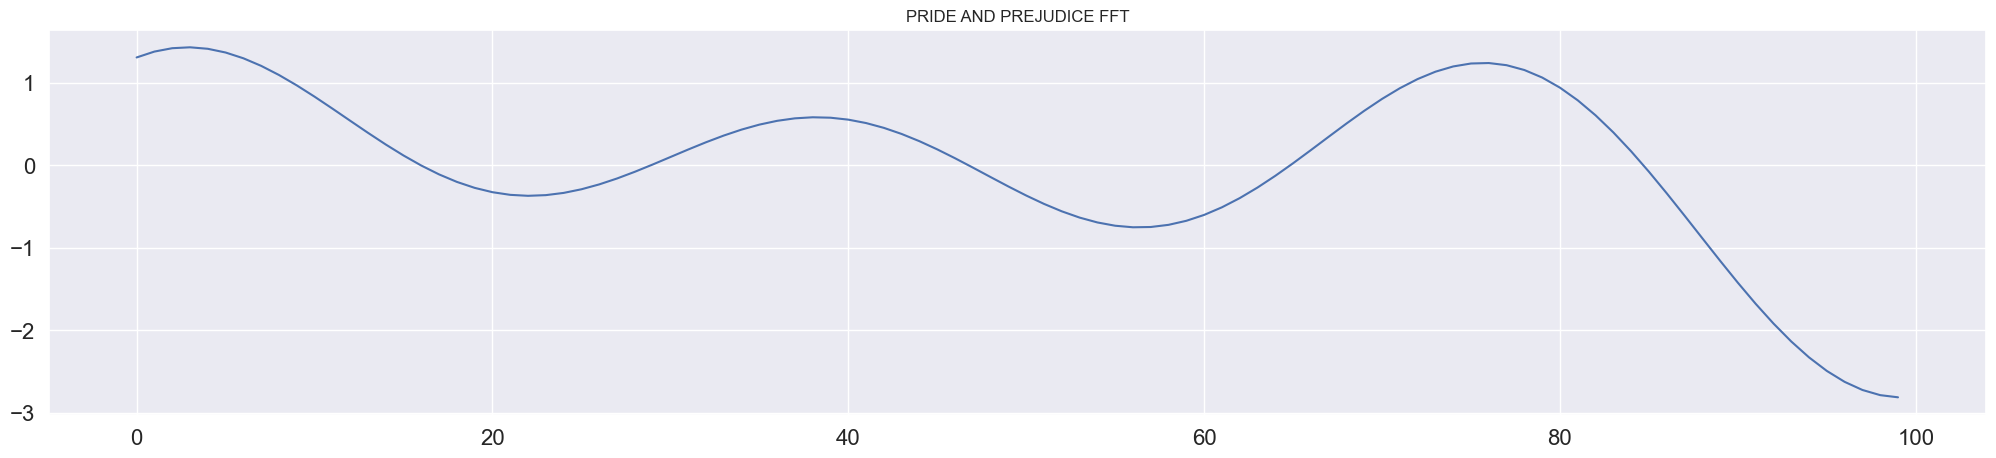

In [37]:
pg1342.plot_smooth('FFT', low_pass_size=3)

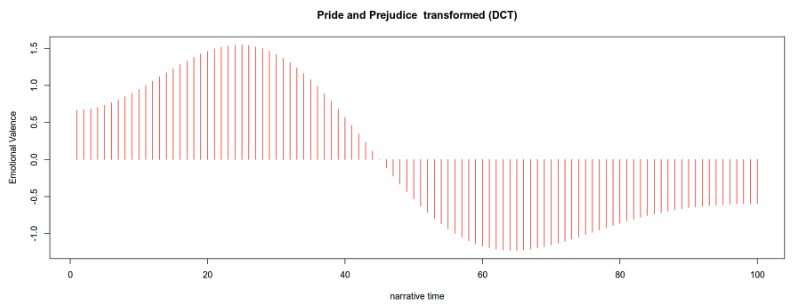

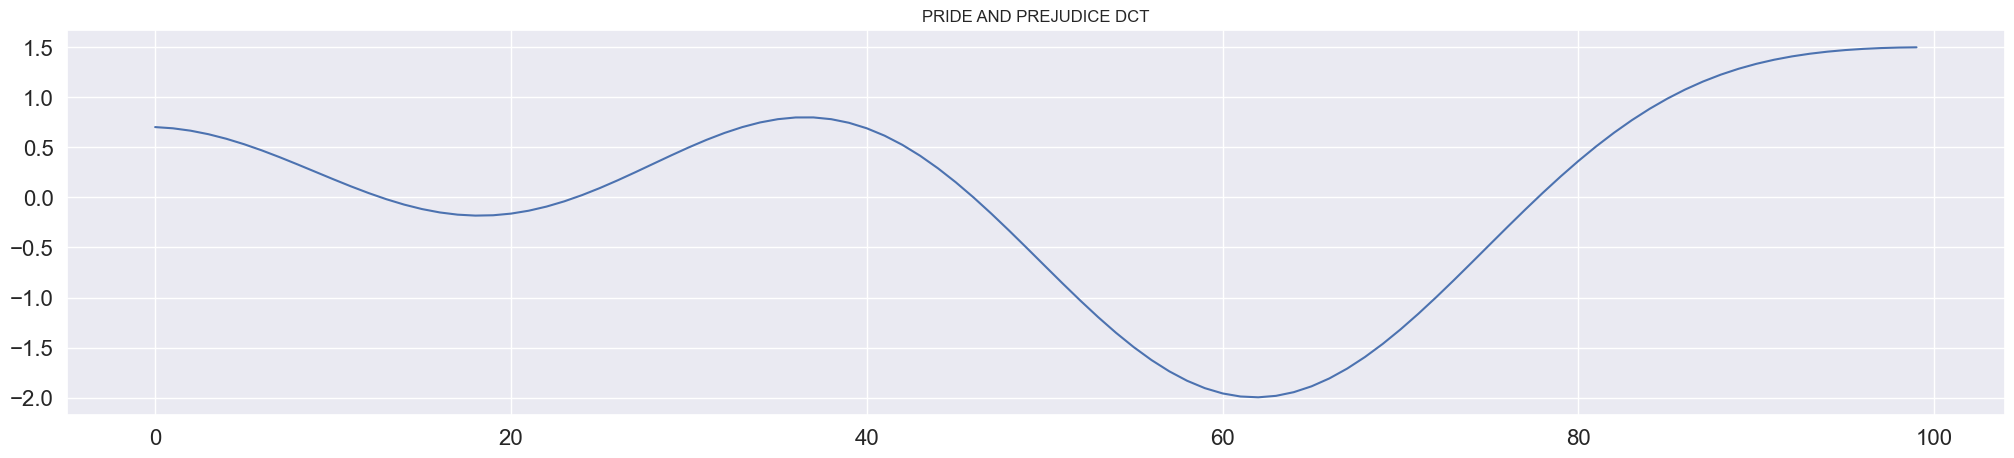

In [38]:
pg1342.plot_smooth()

## Northanger Abbey

In [39]:
northangerabbey = SyuzhetBook(*get_sent_vec('northangerabbey'))

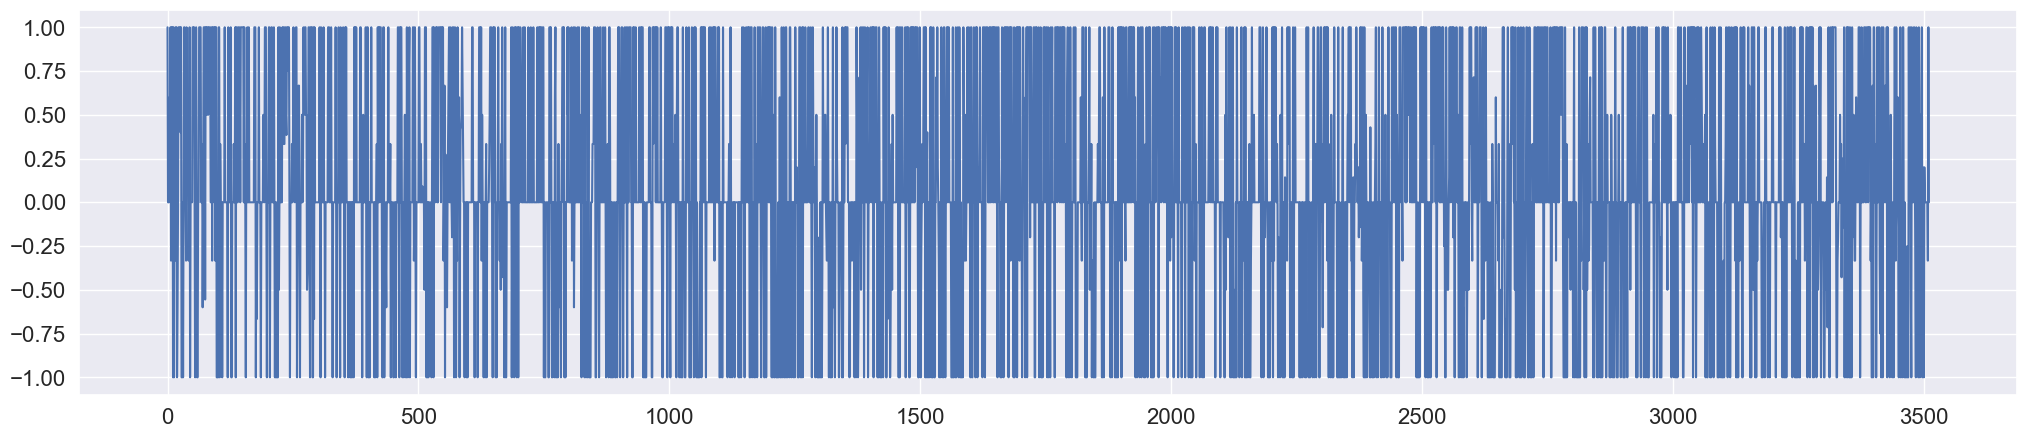

In [40]:
northangerabbey.plot_raw()

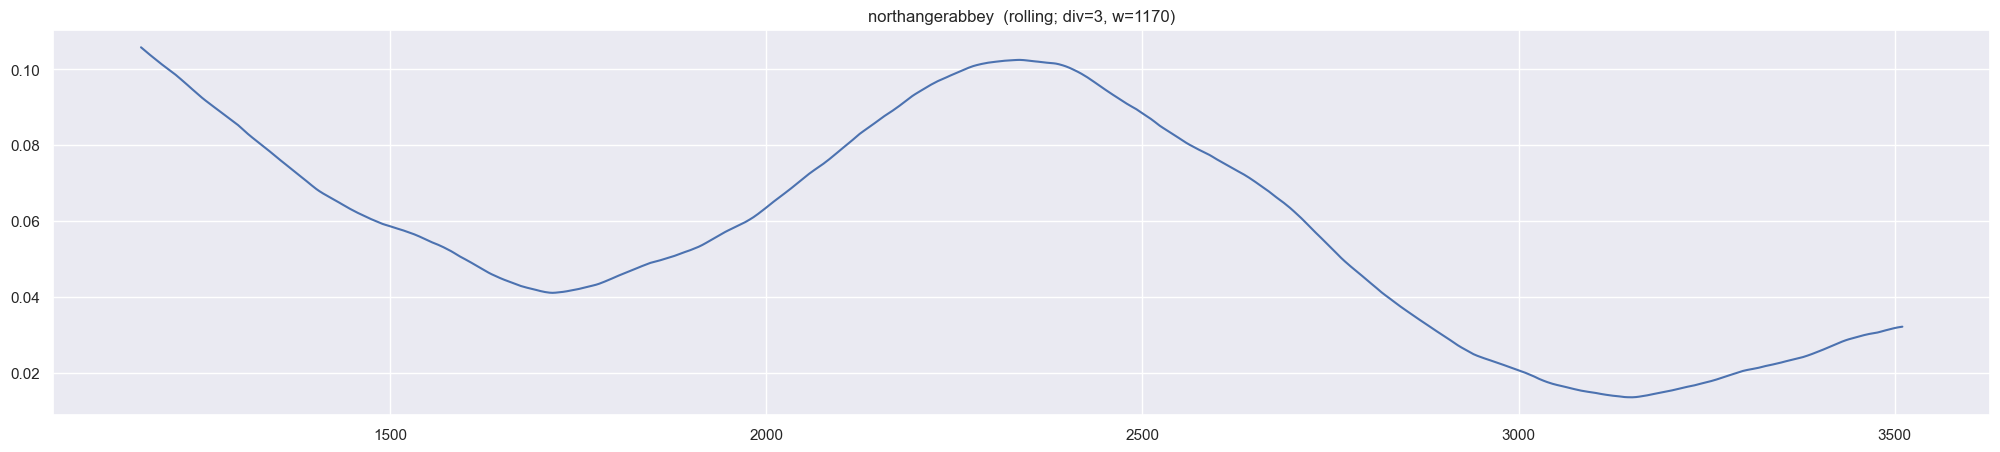

In [41]:
northangerabbey.plot_rolling()

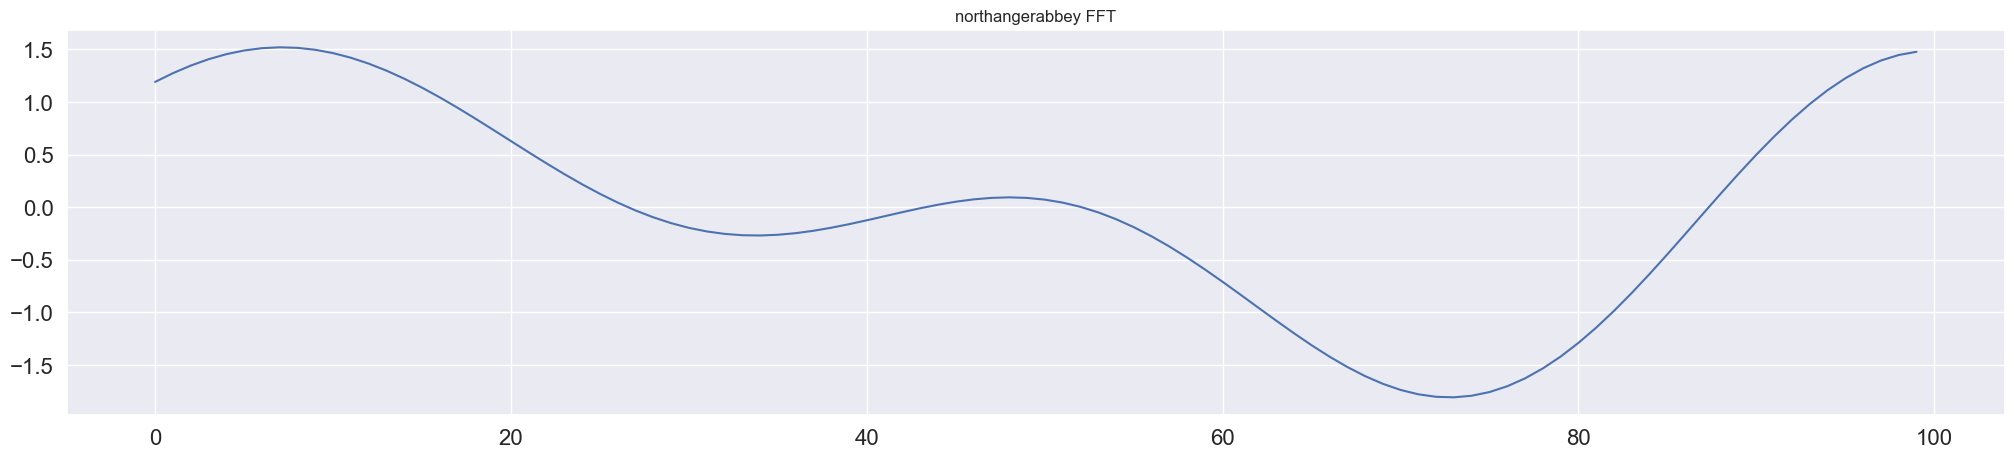

In [42]:
northangerabbey.plot_smooth('FFT', low_pass_size=3)

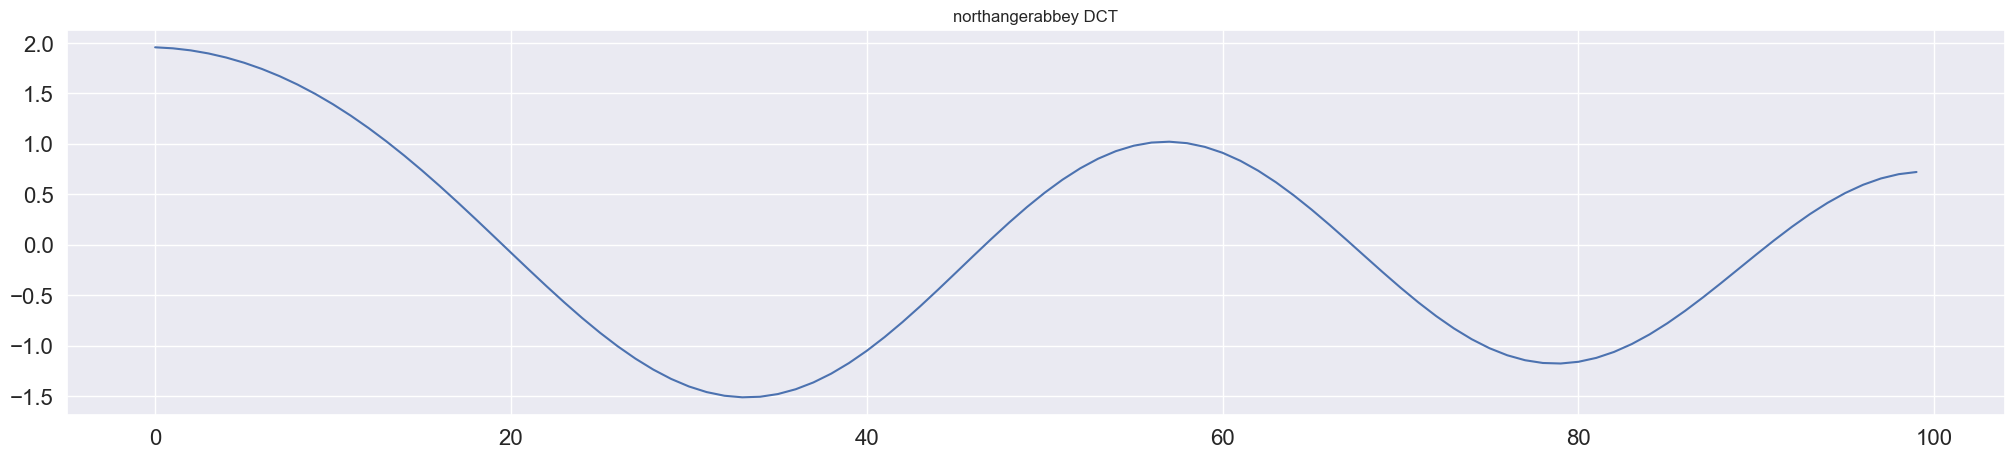

In [43]:
northangerabbey.plot_smooth()

**Federalist**:
> In the end, the two are wed. In the final pages of “Northanger Abbey,” Austen writes that the couple was brought together through mutual affection and that Henry Tinley’s affection for Catherine is rooted in gratitude for her feelings for him. **She’s implying that the typically overwrought and dramatic type of romance on display in most fictitious works does not hold a candle to real love that is rooted in a commitment to one’s husband or wife.** Happy endings and “perfect happiness” are often brought about through ordinary and conventional means — means that ought not to be dismissed because they are **less sexy** than the conventions used in a Gothic novel. \
https://thefederalist.com/2018/10/09/jane-austen-pulled-off-feat-genius-northanger-abbey/

**Schmoop**:

>Northanger Abbey has **a very neat and tidy and rather clichéd ending**: all the nice main characters get married to other nice characters and live happily ever after. All the mean characters end up alone. It's like a Disney movie.\
\
Aside from being rather predictable, **this ending is also a little weird**. What's odd about this ending is that the entire novel spends a lot of time undermining the various clichés of popular Gothic novels. But it ends with a series of giant clichés, including a deus ex machina, which is a fancy Latin term meaning a convenient plot element that is dropped in out of nowhere. The deus ex machina here is that one of the nice and long suffering characters happens to marry a wealthy Viscount who has never before been mentioned. It's completely random. And the narrator even admits that this is pretty weird and random. \
\
The novel's ending isn't just clichéd, **it's totally over-the-top clichéd**. So, rather than being out of step with the rest of the book, the ending actually bumps the satire up a notch and goes for broke. Like the rest of the book, the ending is still highly satirical – **it exaggerates and mocks the types of sentimental and even ludicrous endings often found in Gothic novels**. The ending just accomplishes the satire in a different way than the rest of the book, which relies more on clever dialogue and humorously disrupted expectations. Instead of letting the characters supply the humor through their words and actions, the ending utilizes outrageous plot devices and ironic narrative commentary. Still, why Jane Austen decided to go with an over-the-top ending instead of a more subtle ending is debatable.\
https://www.shmoop.com/study-guides/literature/northanger-abbey/analysis/ending

# By other bags (DCT only)

In [44]:
lps = 6
alt_bag = 'PARAS'

In [45]:
def plot_sent(book_id, bag='PARAS', lps=6):
    SyuzhetBook(*get_sent_vec(book_id, bag=alt_bag)).plot_smooth(low_pass_size=lps)

## Persuasion

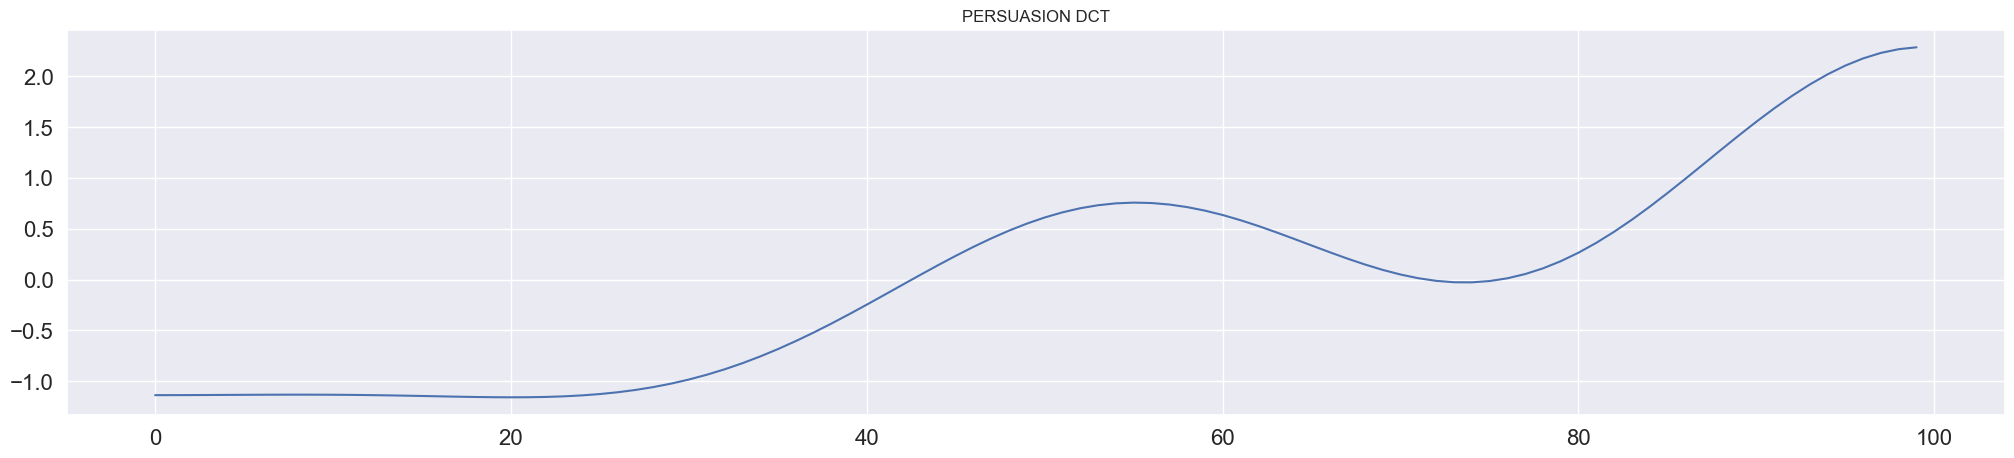

In [46]:
plot_sent(105)

## Moby Dick

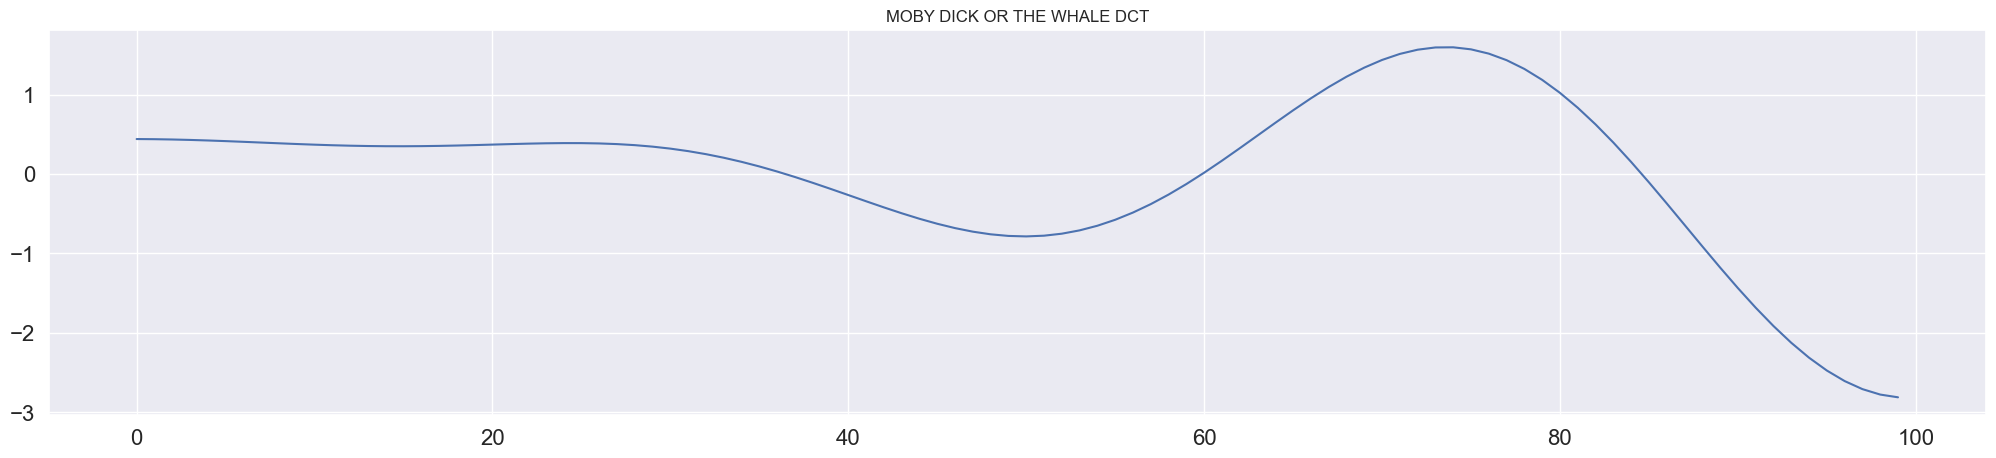

In [47]:
plot_sent(2701)

## Dracula

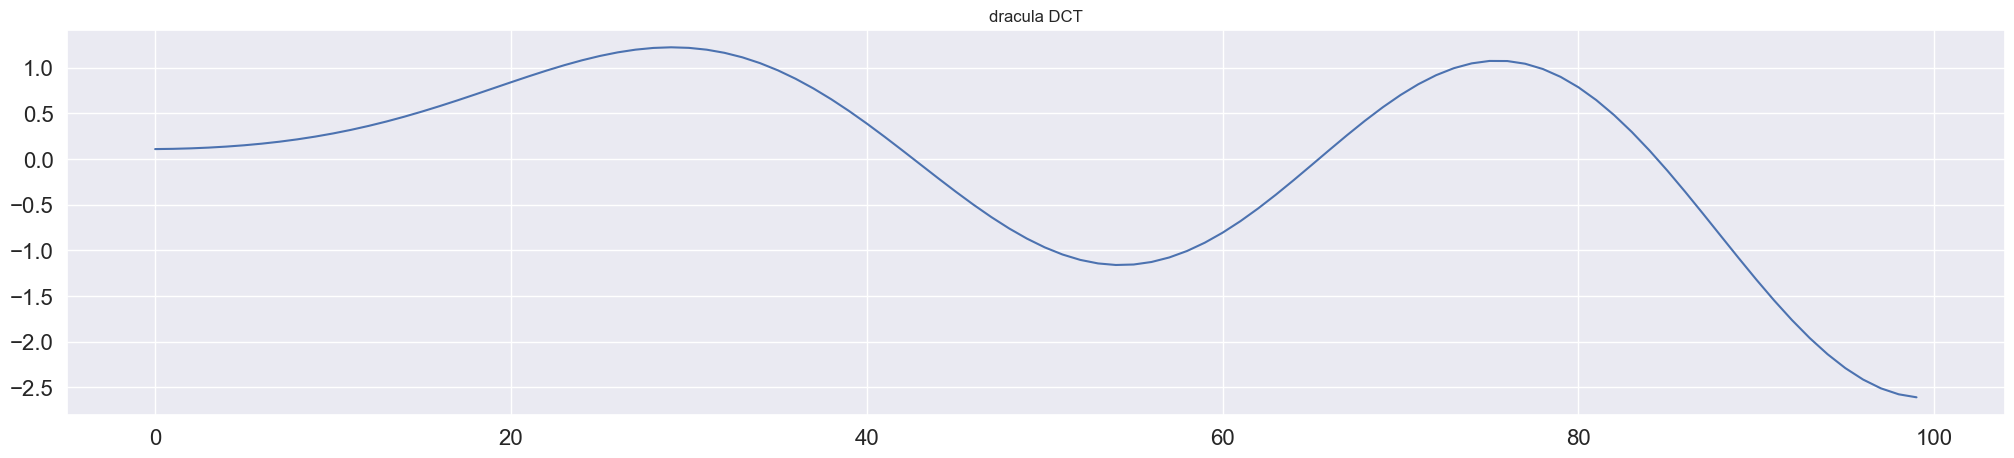

In [48]:
plot_sent('dracula')

## Frankenstein

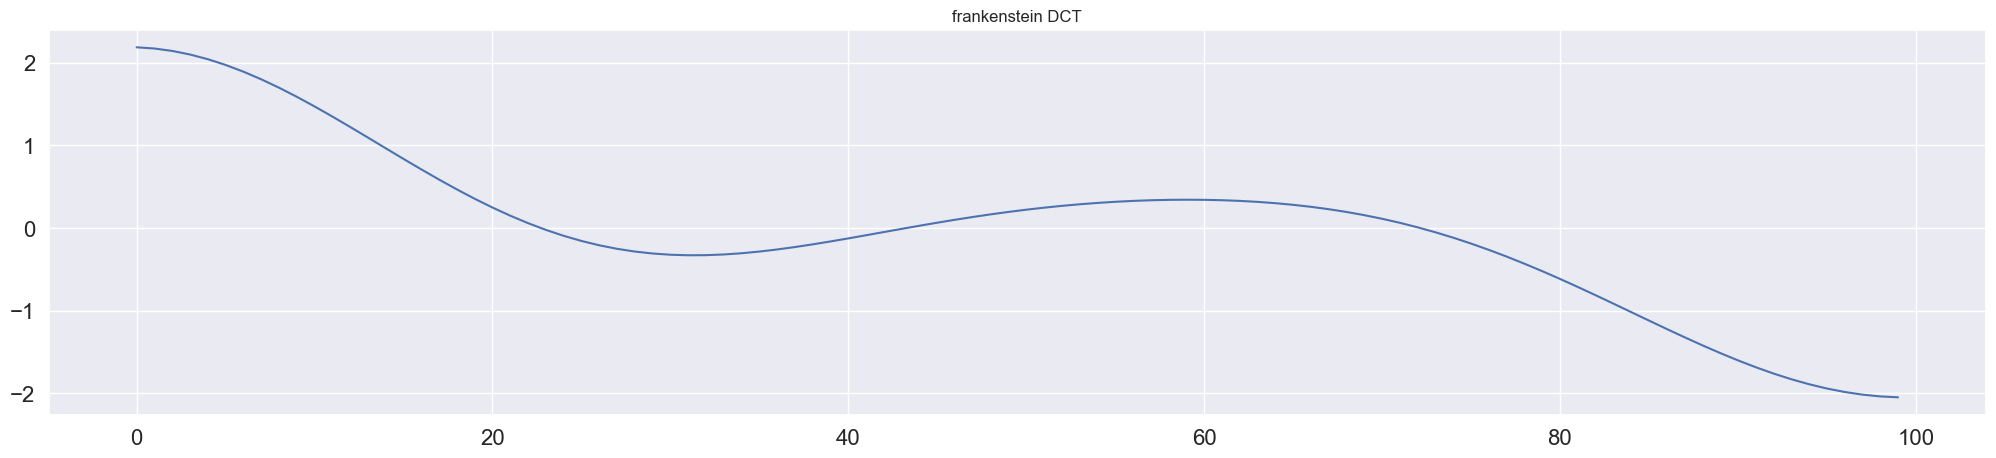

In [49]:
plot_sent('frankenstein')

# Cluster

In [50]:
import sys
sys.path.append(local_lib)
from hac2 import HAC

In [51]:
X = M[bag].groupby('book_id').apply(lambda x: pd.Series(Transforms.DCT(x.reset_index(drop=True)[f"{sent_col}_sentiment"])))

In [52]:
LIB['label'] = (LIB.author_id + '-' + LIB.title.str.upper().str[:10] + '_' + LIB.title.str.upper().str[-10:]).str.replace(' ', '_') + '/' + LIB.index
labels = LIB.sort_index().label.tolist()

In [53]:
# a = set([str(i) for i in X.index.tolist()])
# b = set(LIB.index.tolist())

<Figure size 640x480 with 0 Axes>

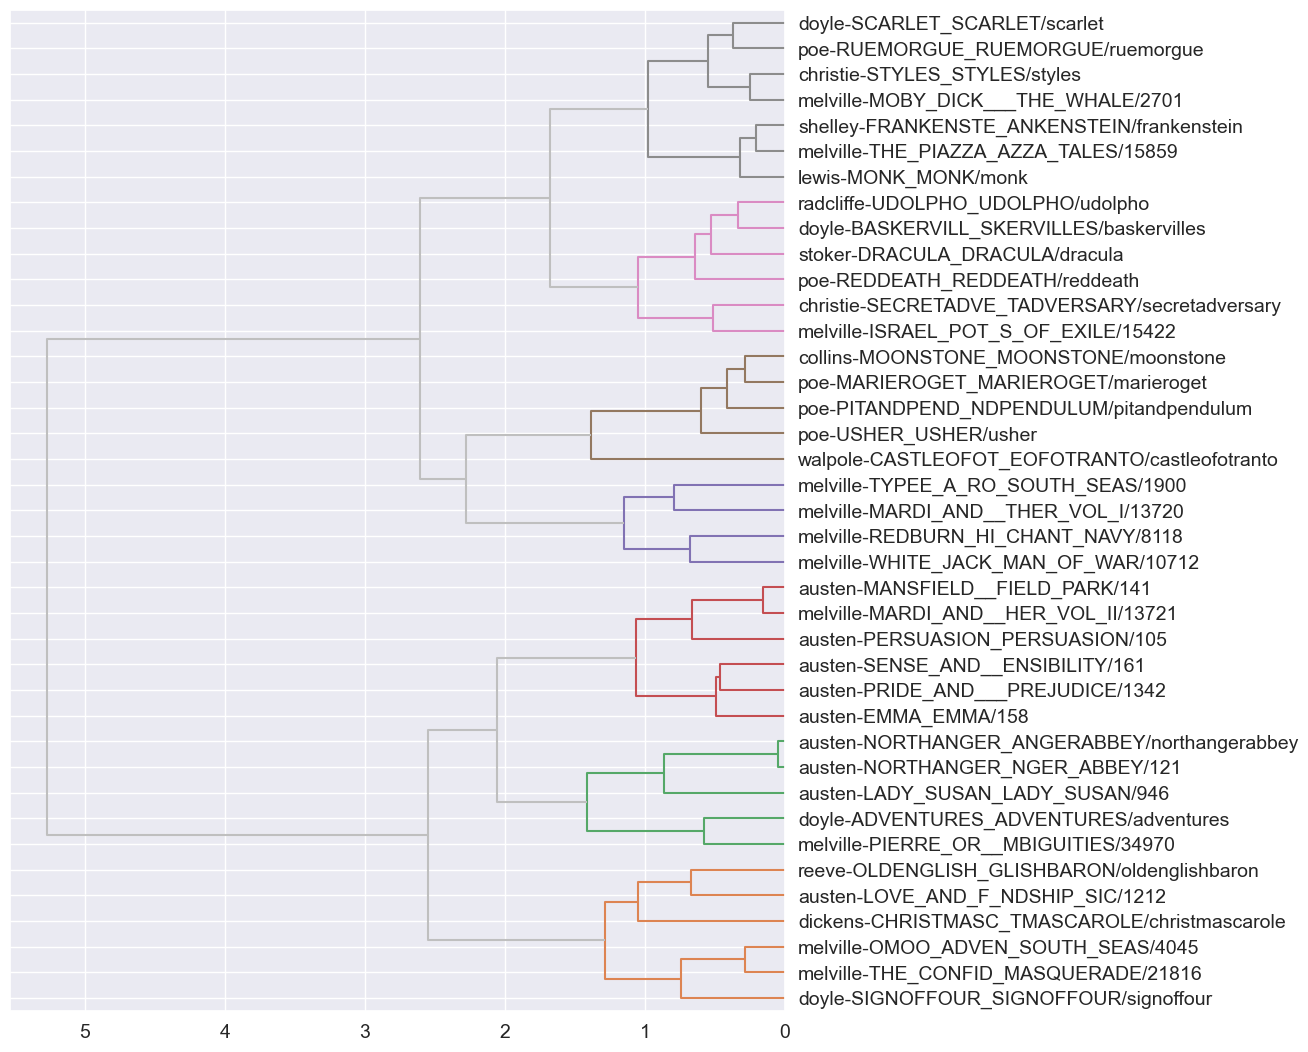

In [54]:
hac = HAC(X, labels=labels)
hac.color_thresh = 1.5
hac.plot();

## Group A1: HI $\rightarrow$ LO 1

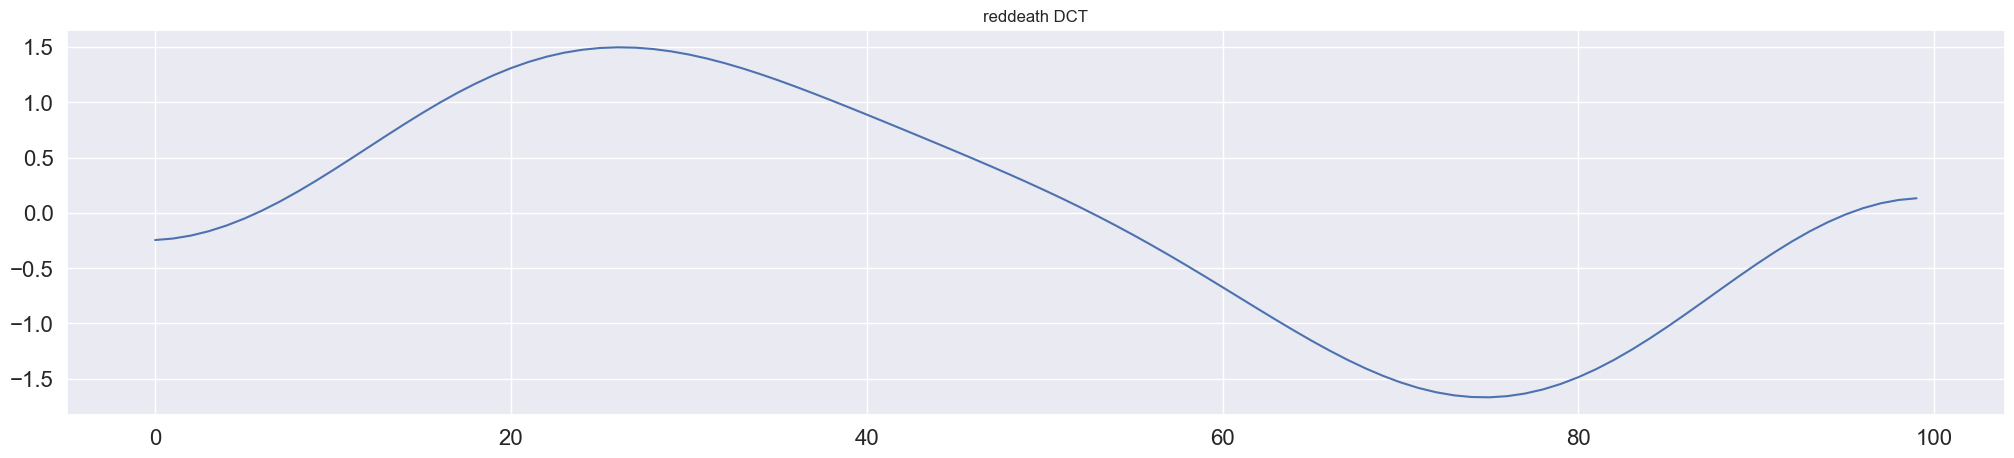

In [55]:
plot_sent('reddeath')

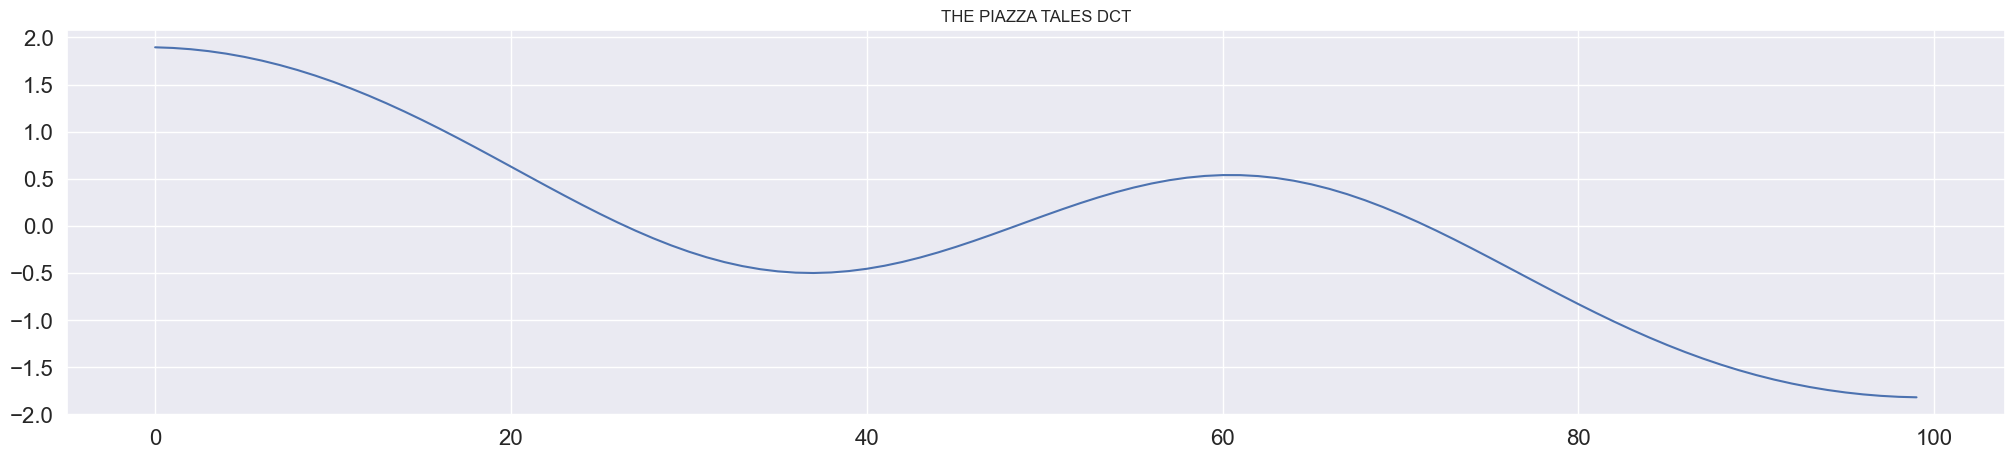

In [56]:
plot_sent(15859)

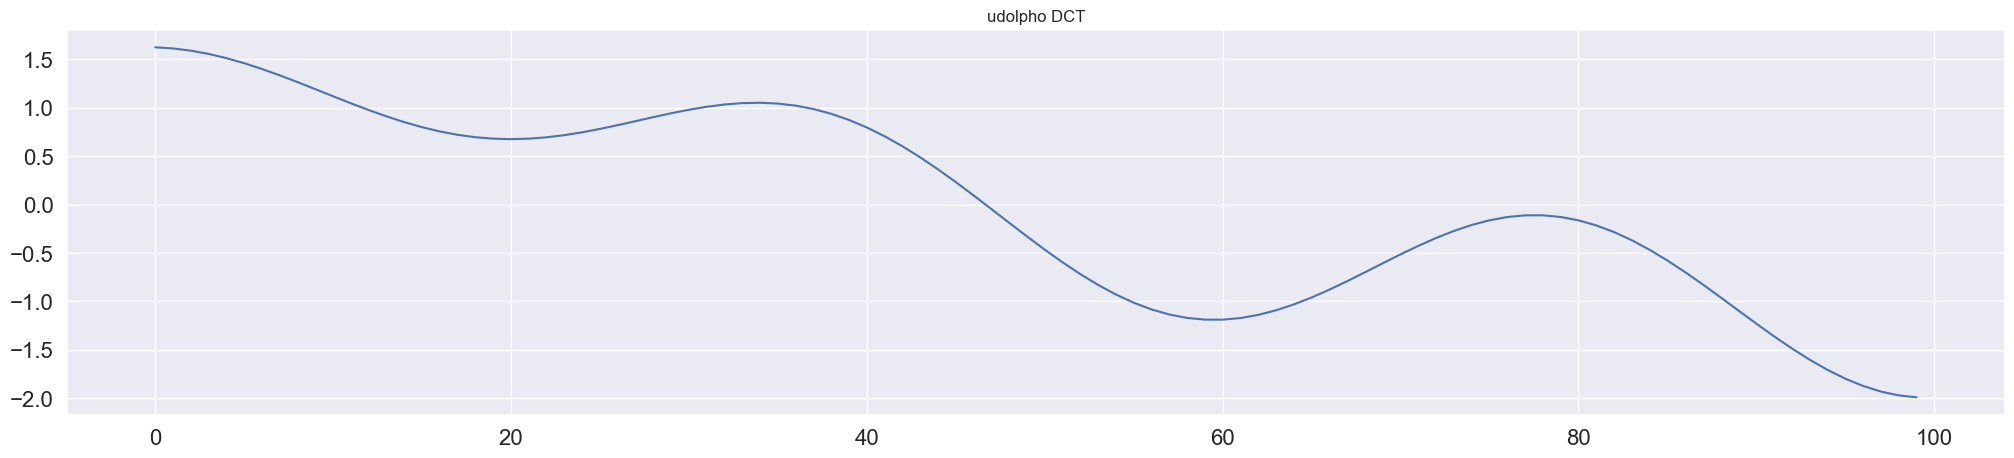

In [57]:
plot_sent('udolpho')

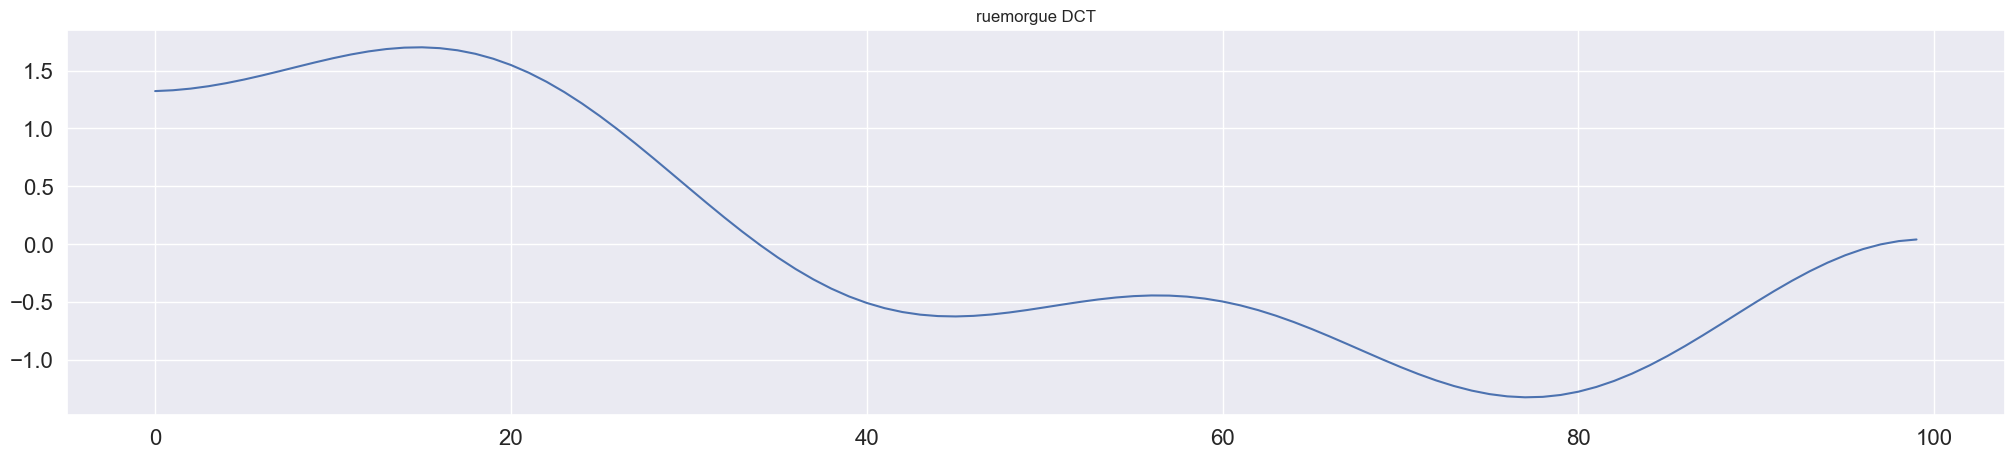

In [58]:
plot_sent('ruemorgue')

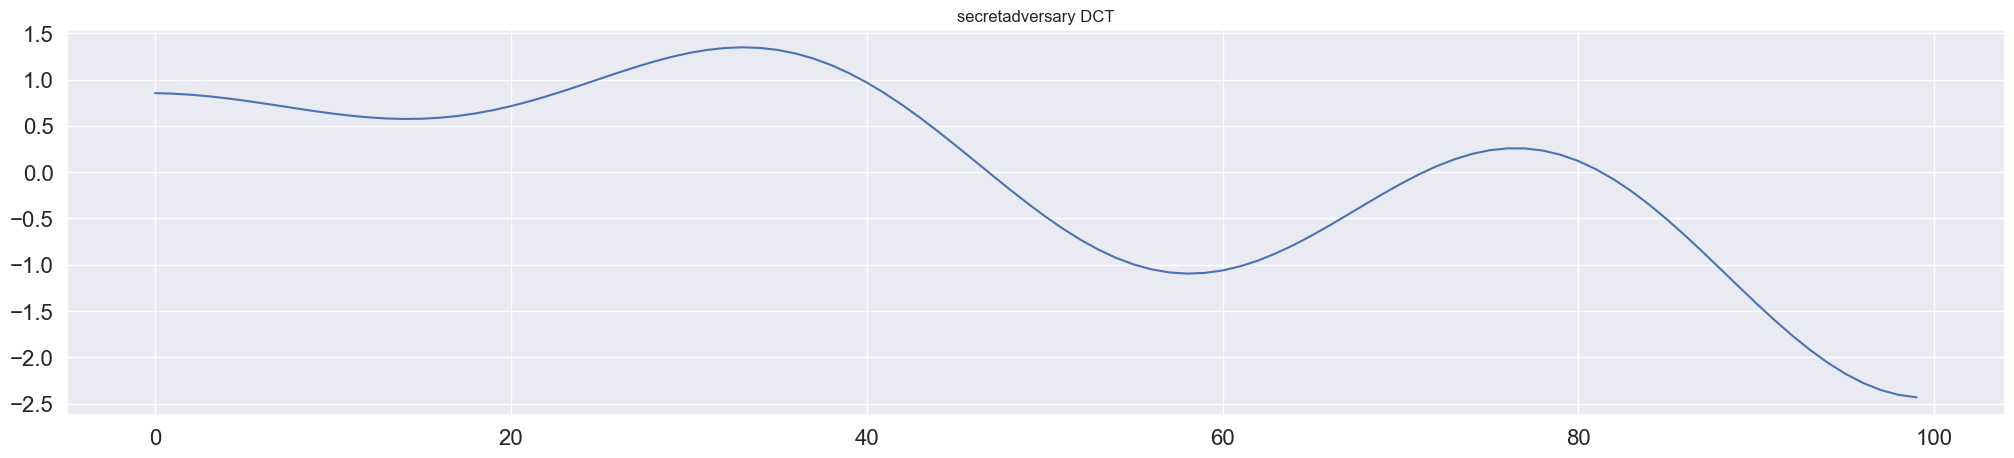

In [59]:
plot_sent('secretadversary')

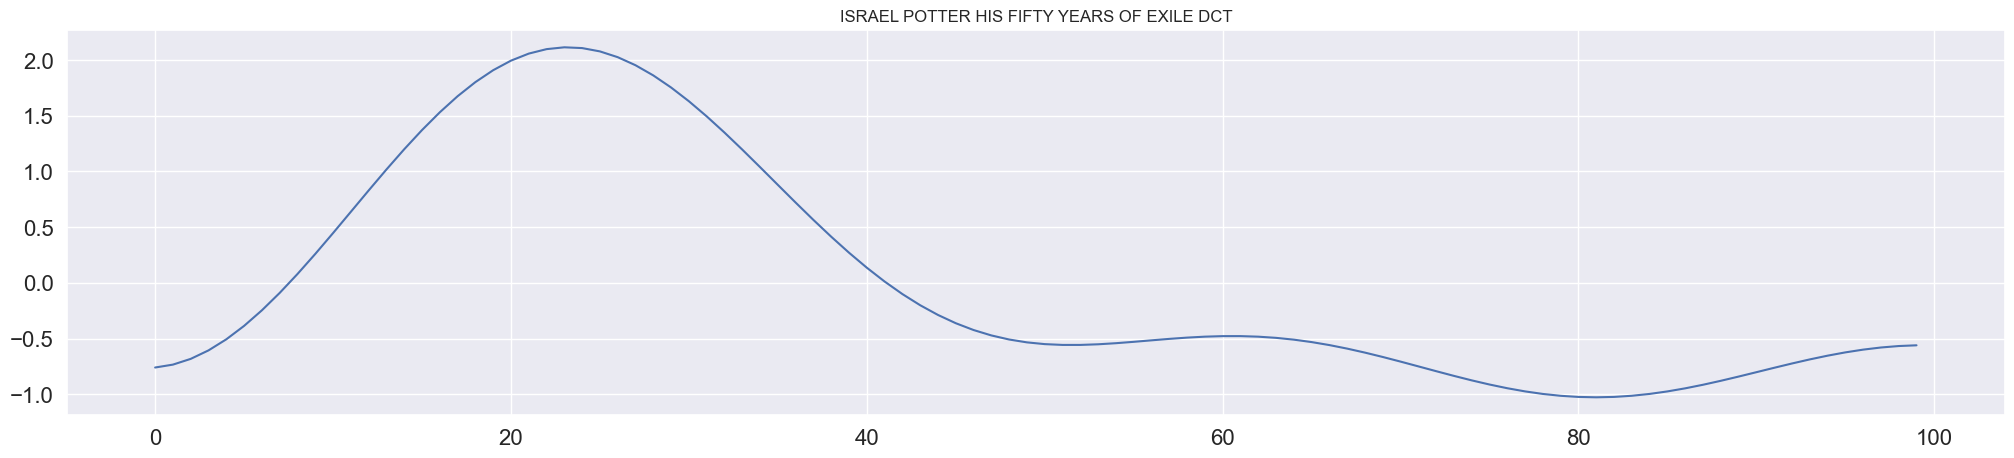

In [60]:
plot_sent(15422)

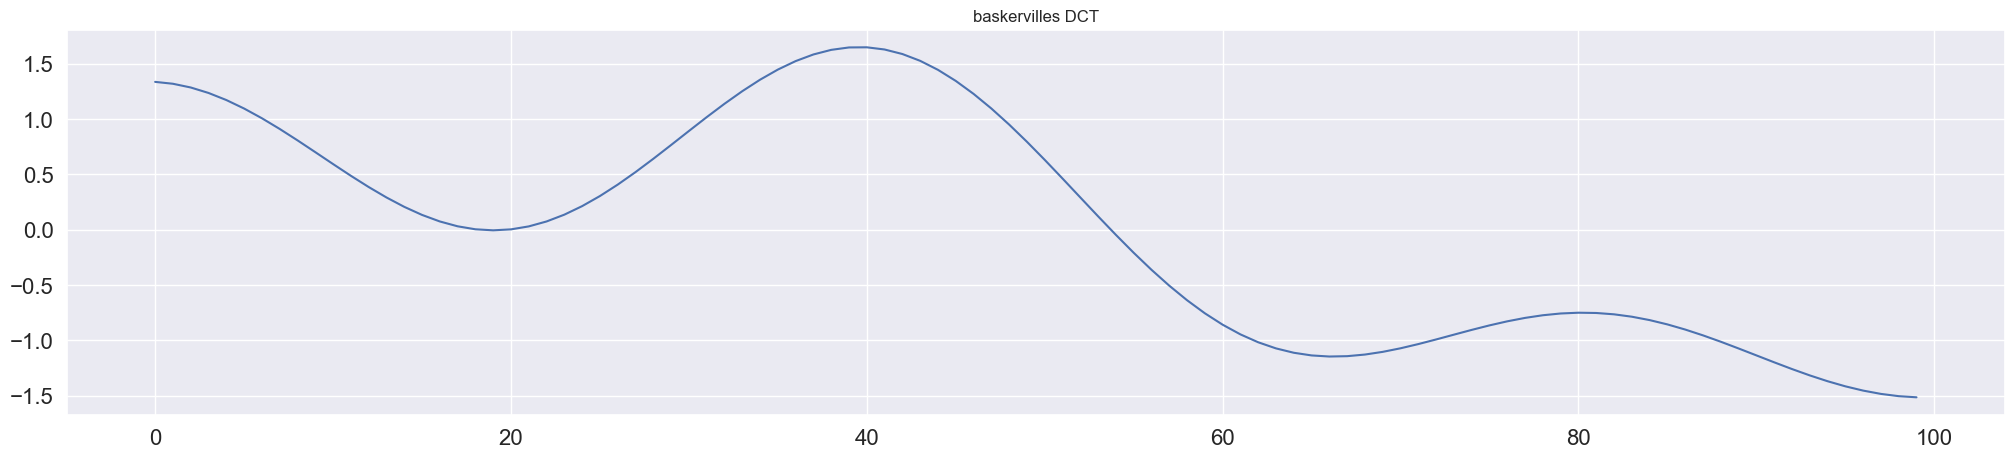

In [61]:
plot_sent('baskervilles')

## Group A2: HI $\rightarrow$ LO 2

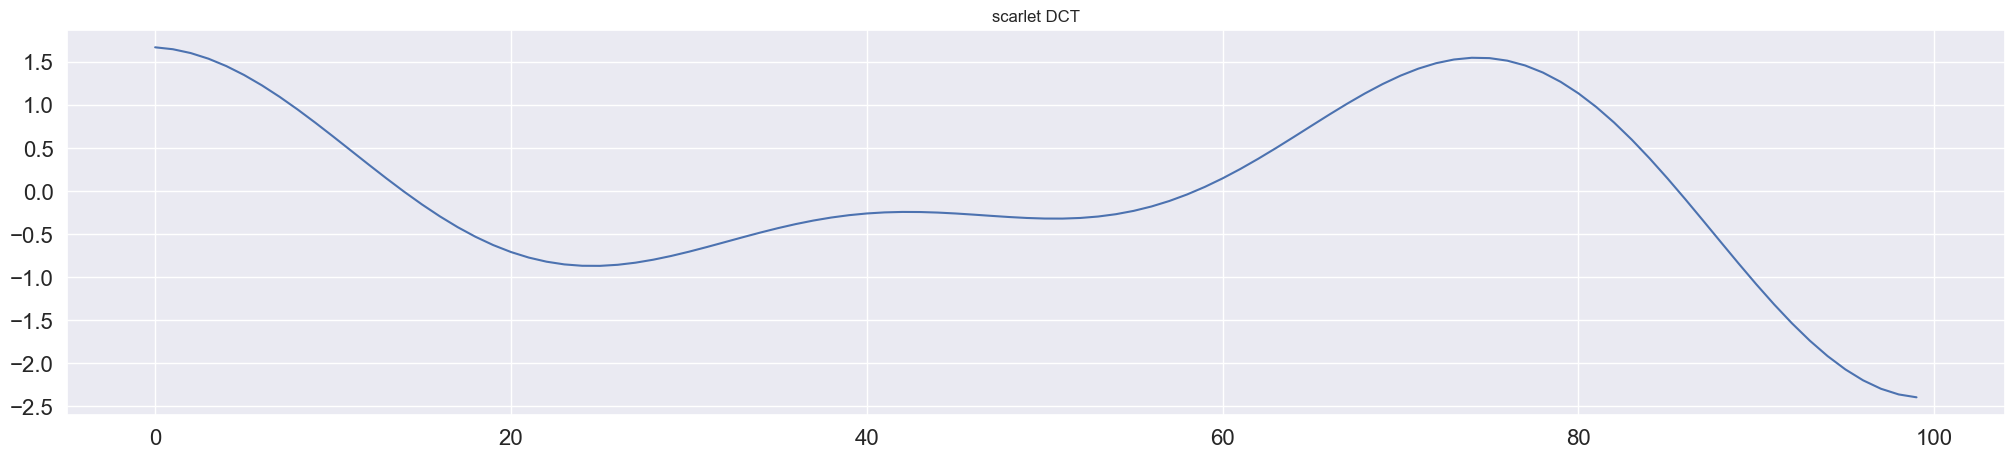

In [62]:
plot_sent('scarlet')

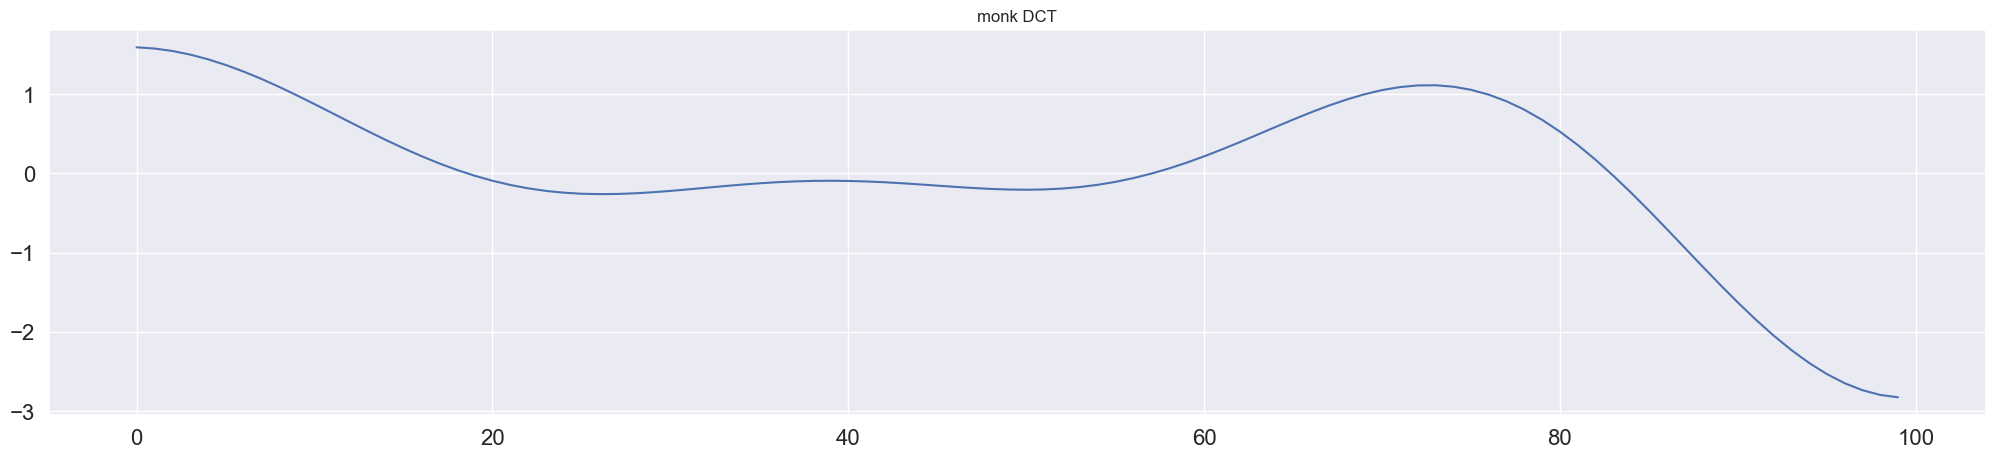

In [63]:
plot_sent('monk')

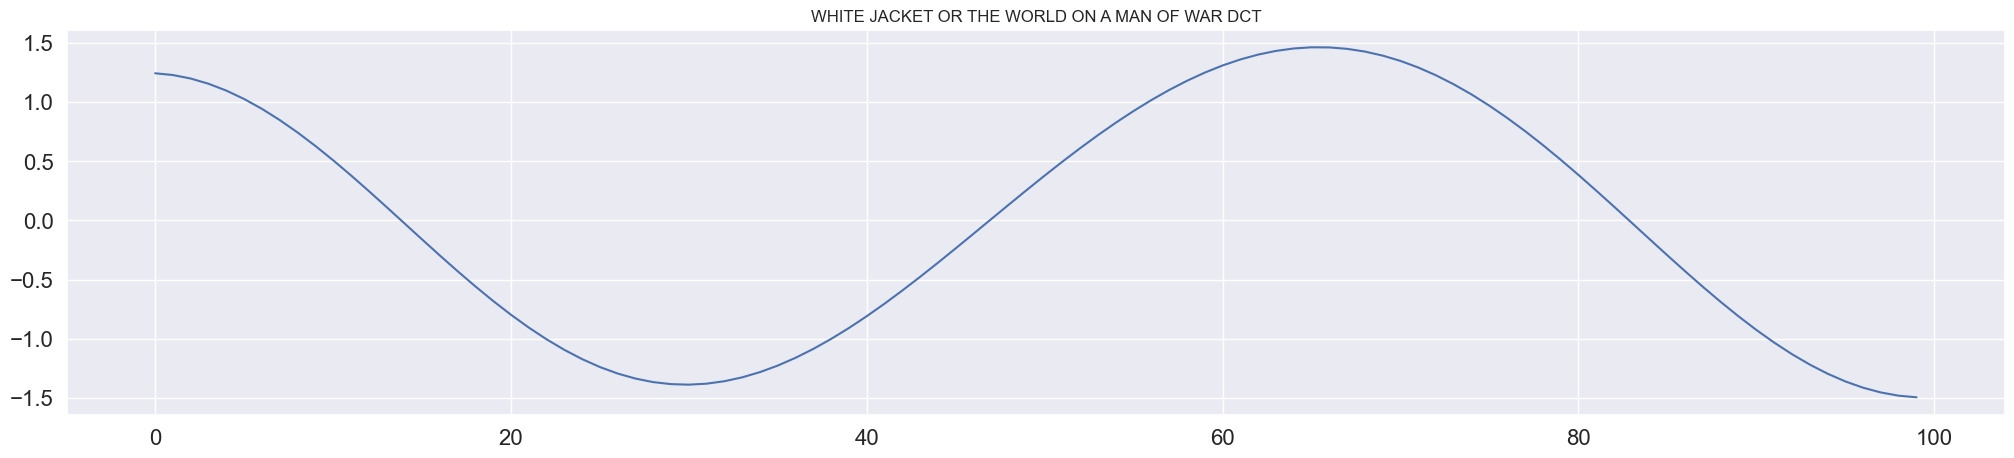

In [64]:
plot_sent(10712)

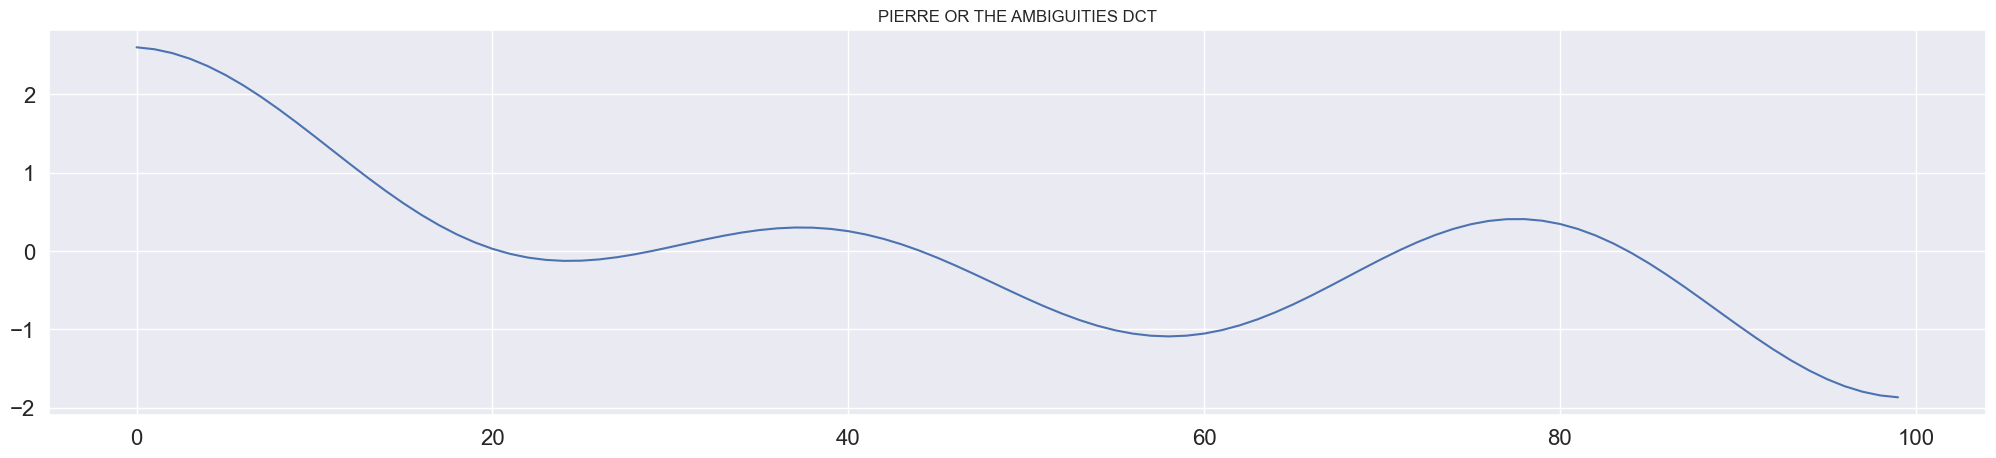

In [65]:
plot_sent(34970)

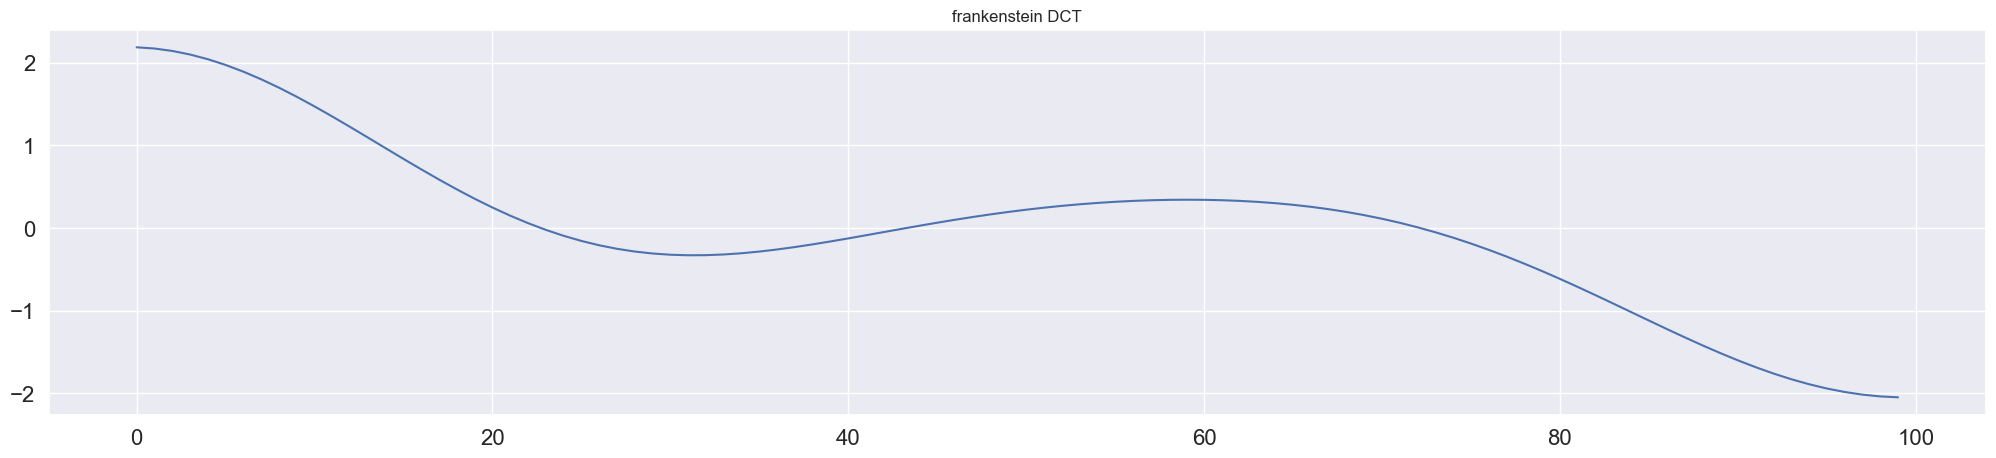

In [66]:
plot_sent('frankenstein')

## Group B: LO $\rightarrow$ HI 1

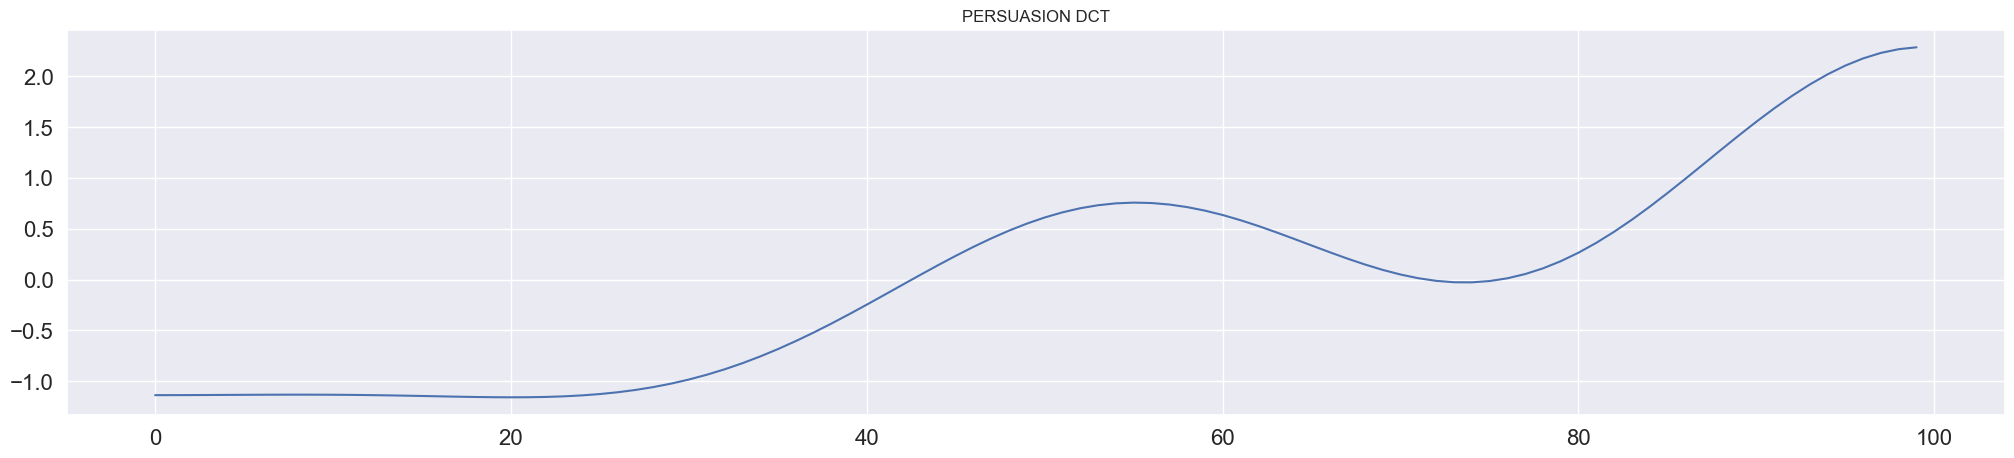

In [67]:
plot_sent(105)

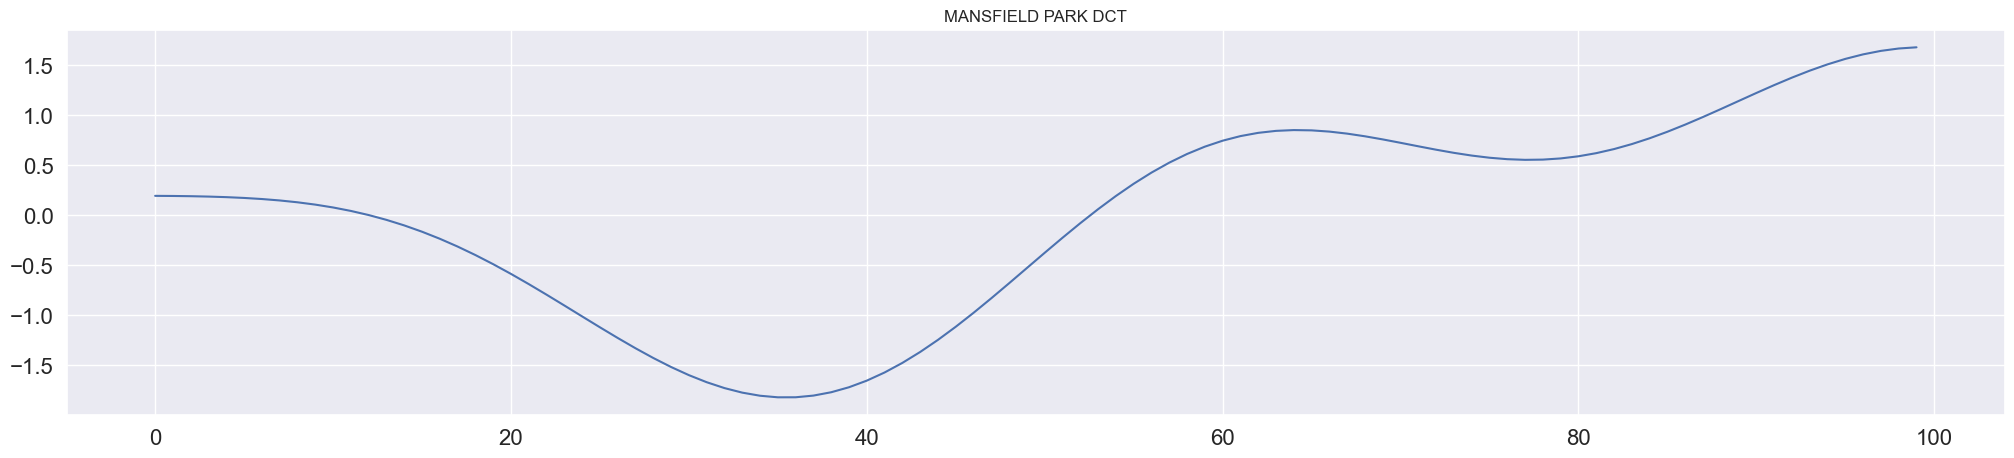

In [68]:
plot_sent(141)

## Group C: LO $\rightarrow$ HI 2

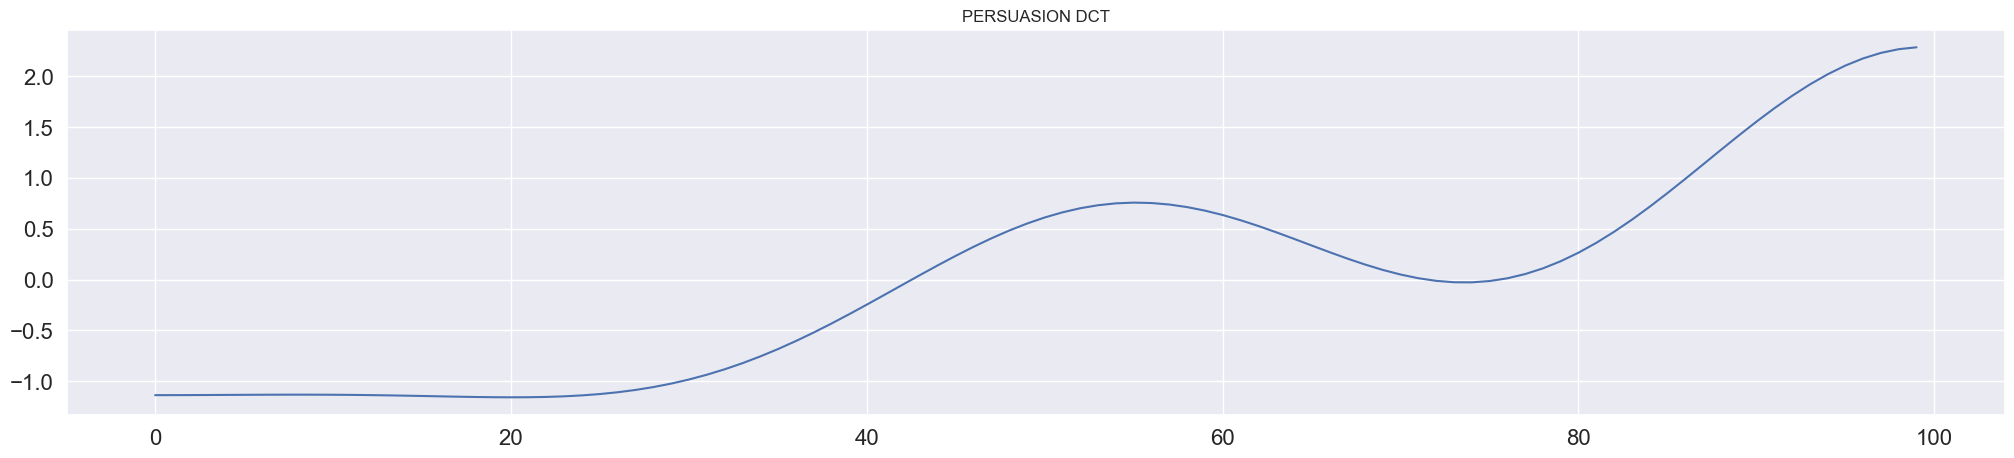

In [69]:
plot_sent(105)

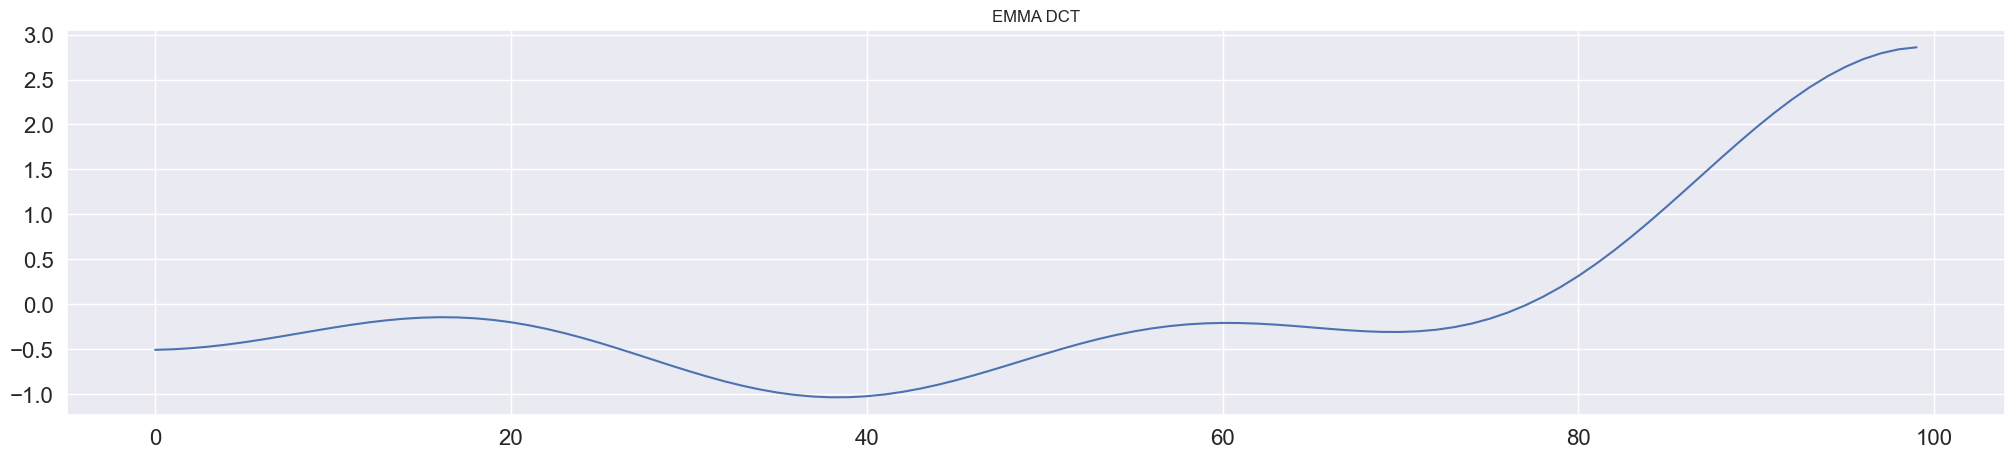

In [70]:
plot_sent(158)

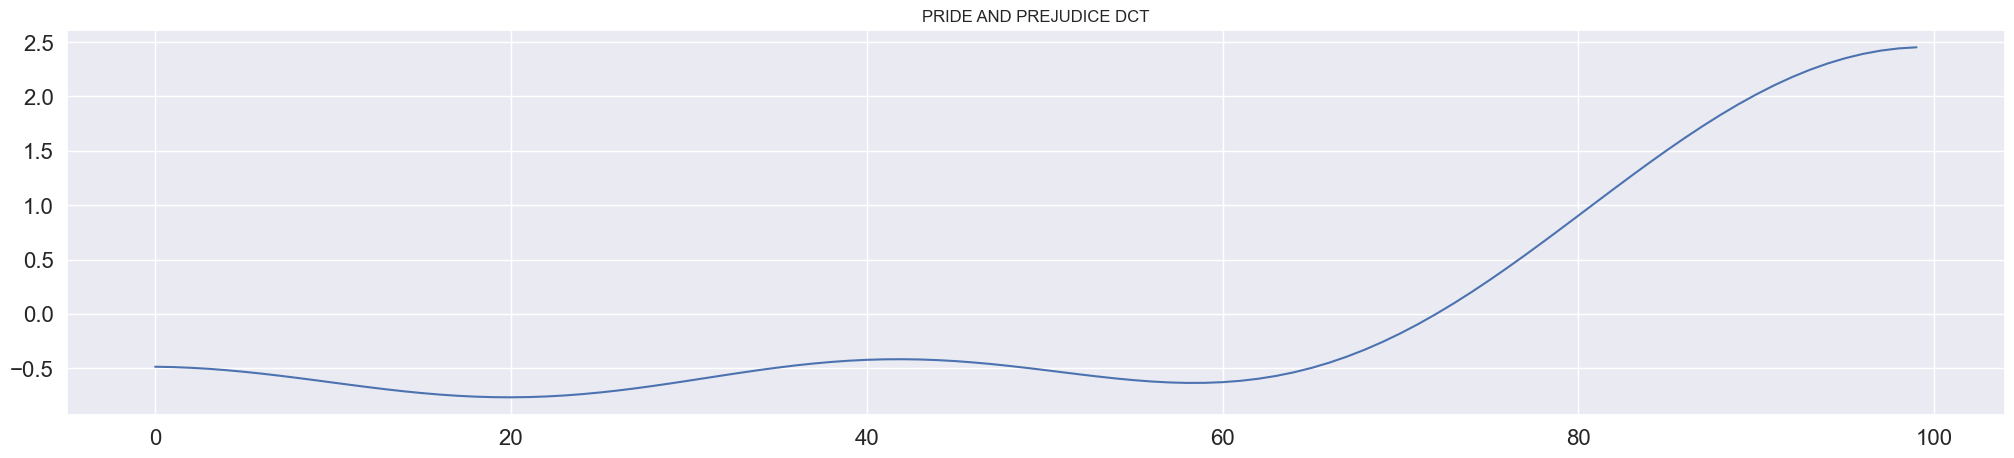

In [71]:
plot_sent(1342)

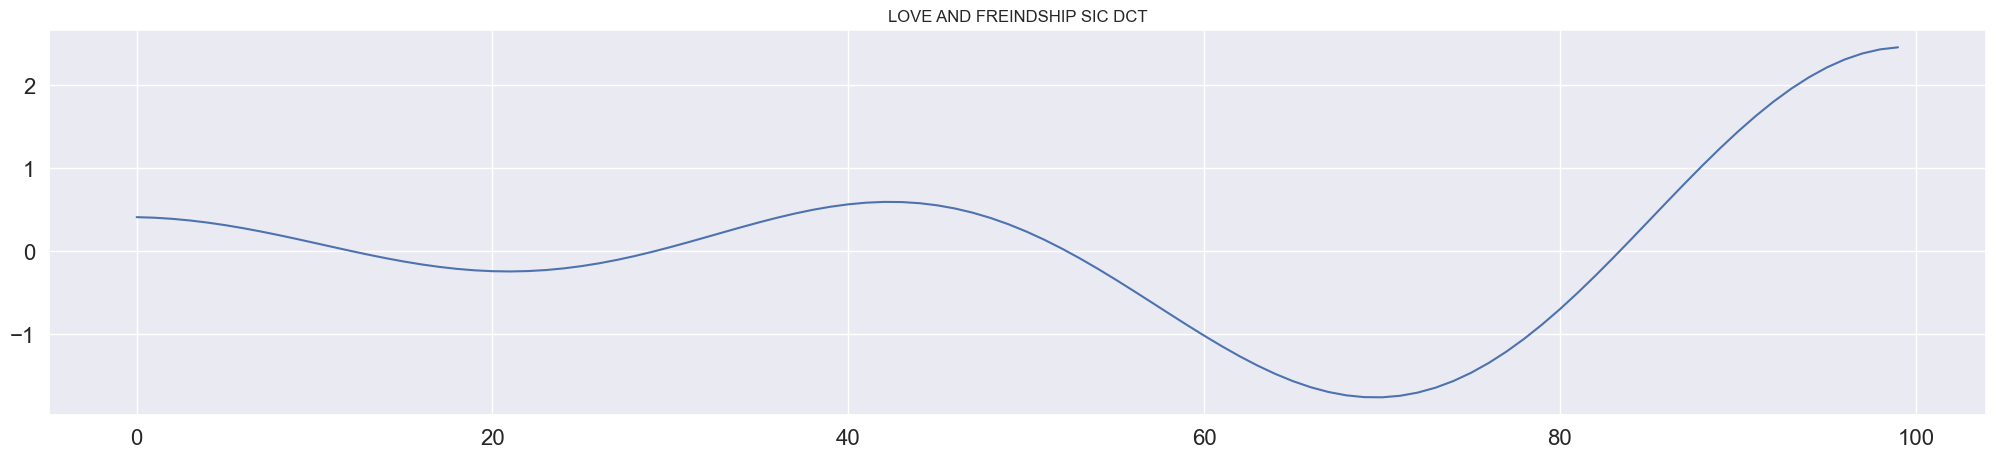

In [72]:
plot_sent(1212)

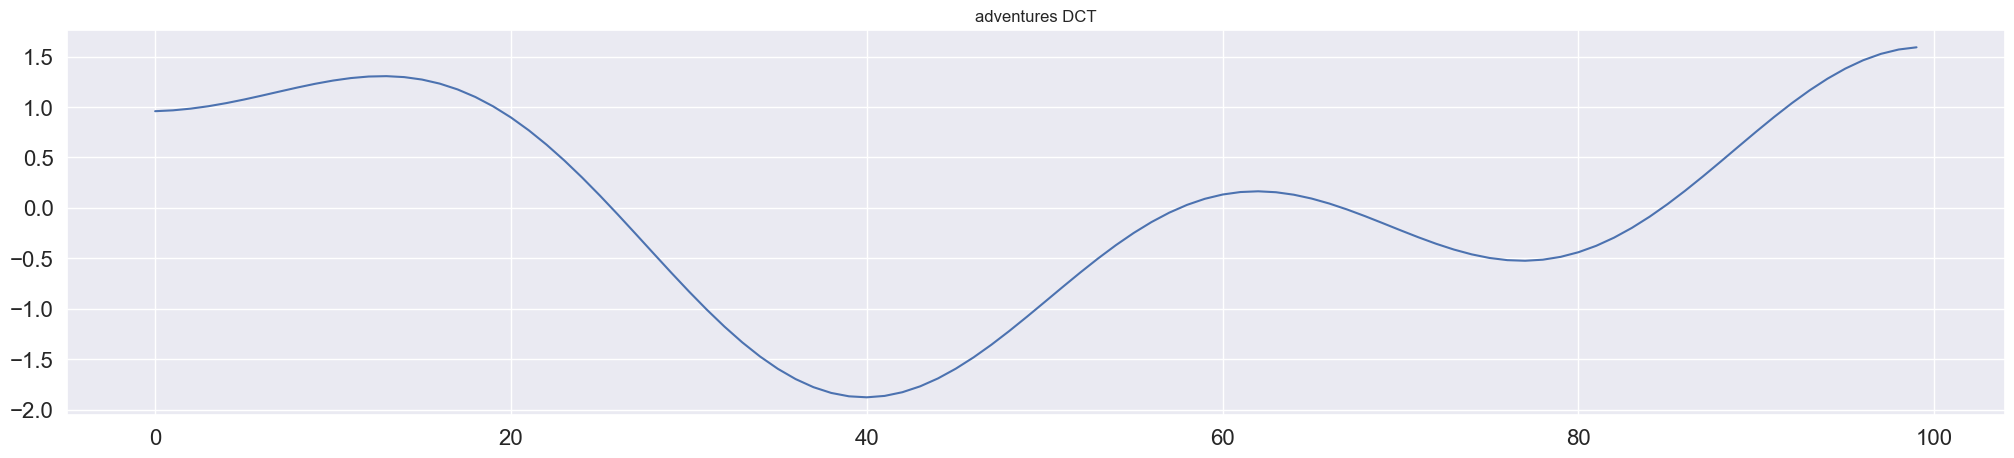

In [73]:
plot_sent('adventures')

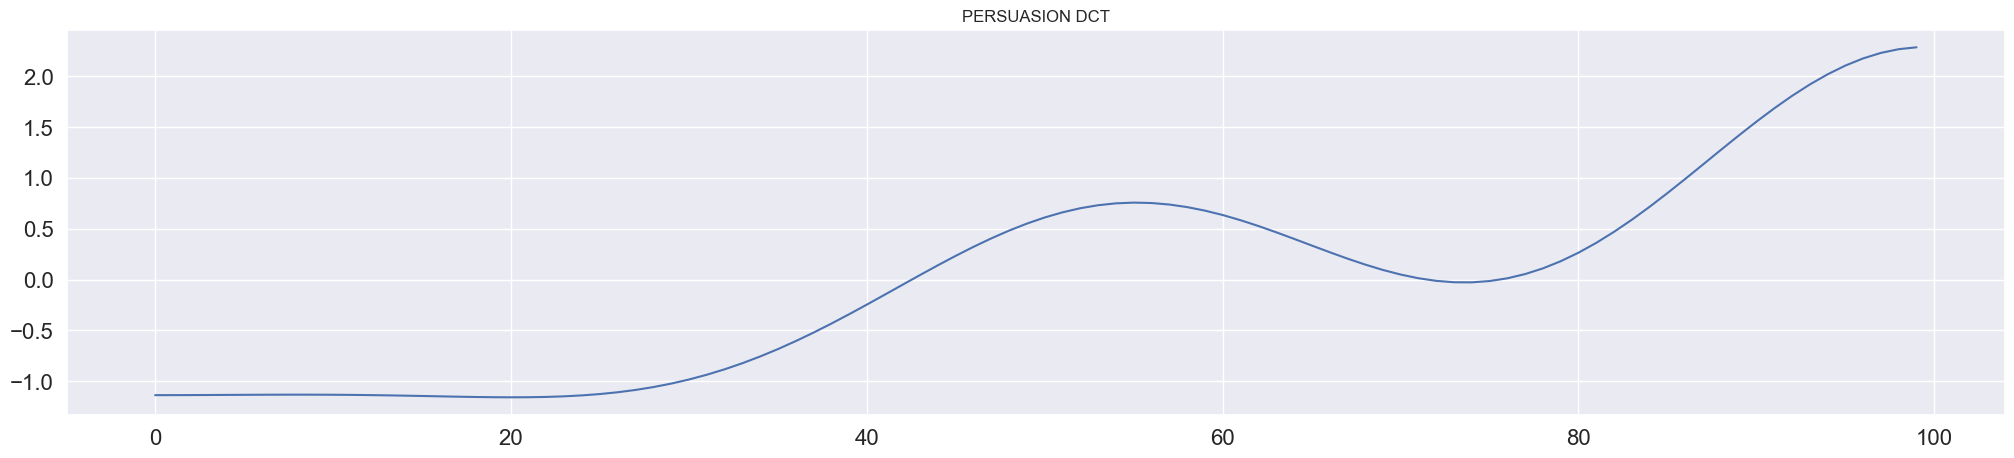

In [74]:
plot_sent(105)

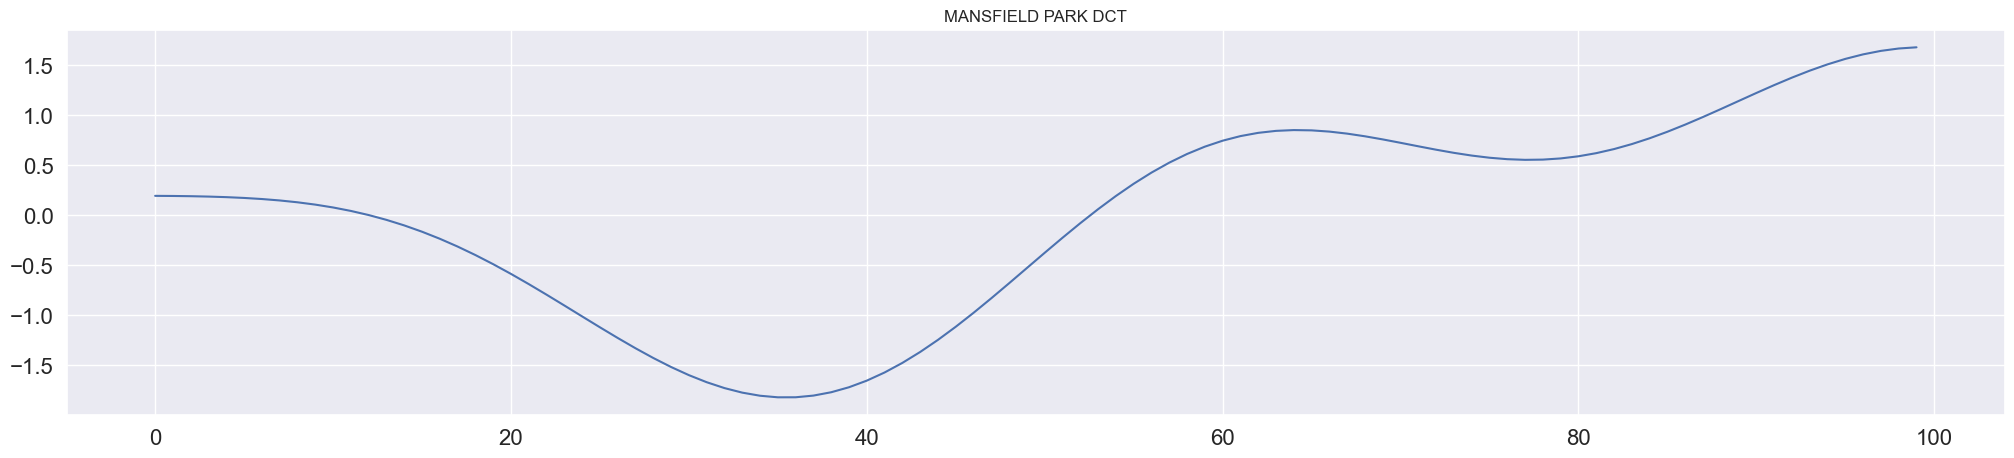

In [75]:
plot_sent(141)

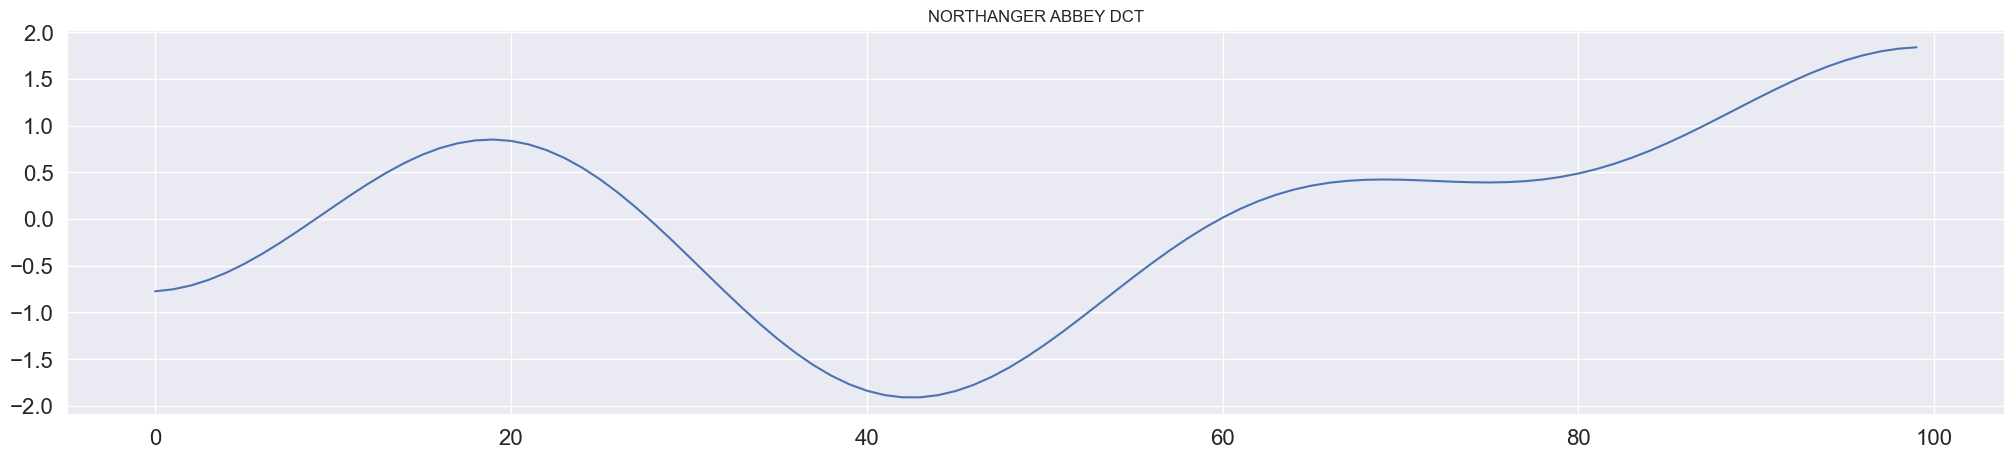

In [76]:
plot_sent(121)

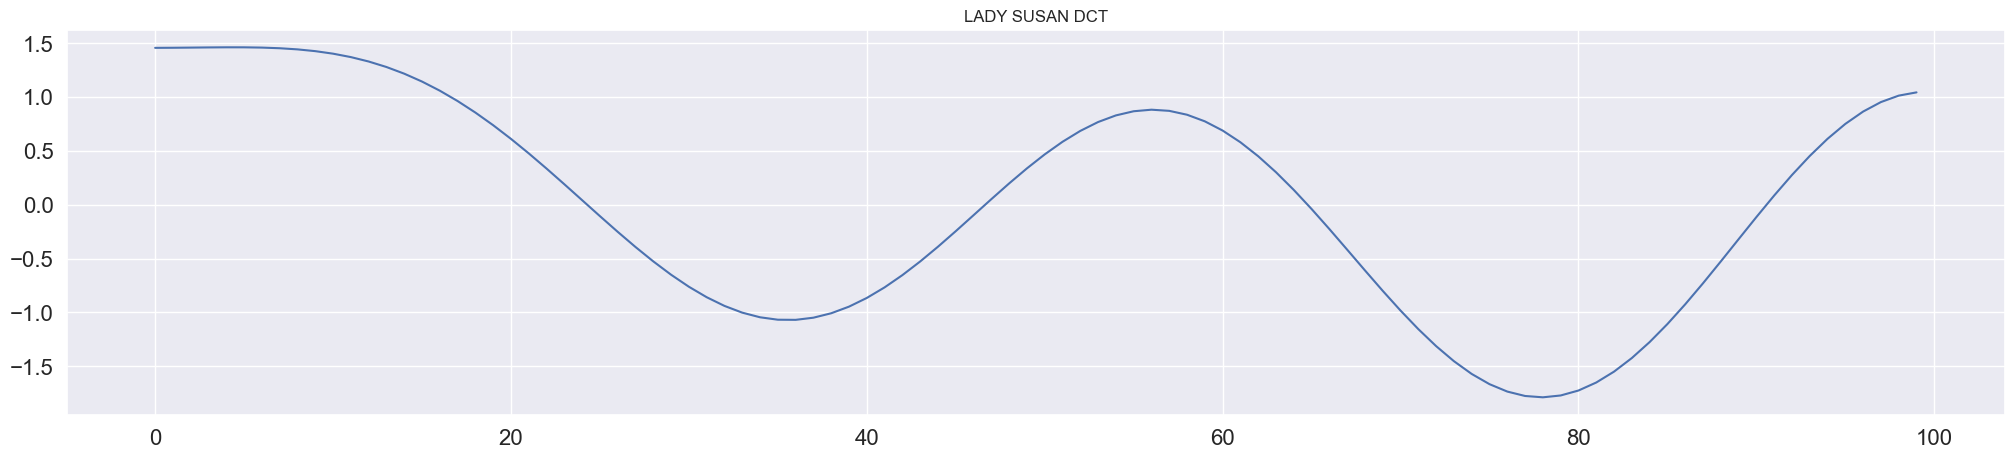

In [77]:
plot_sent(946)

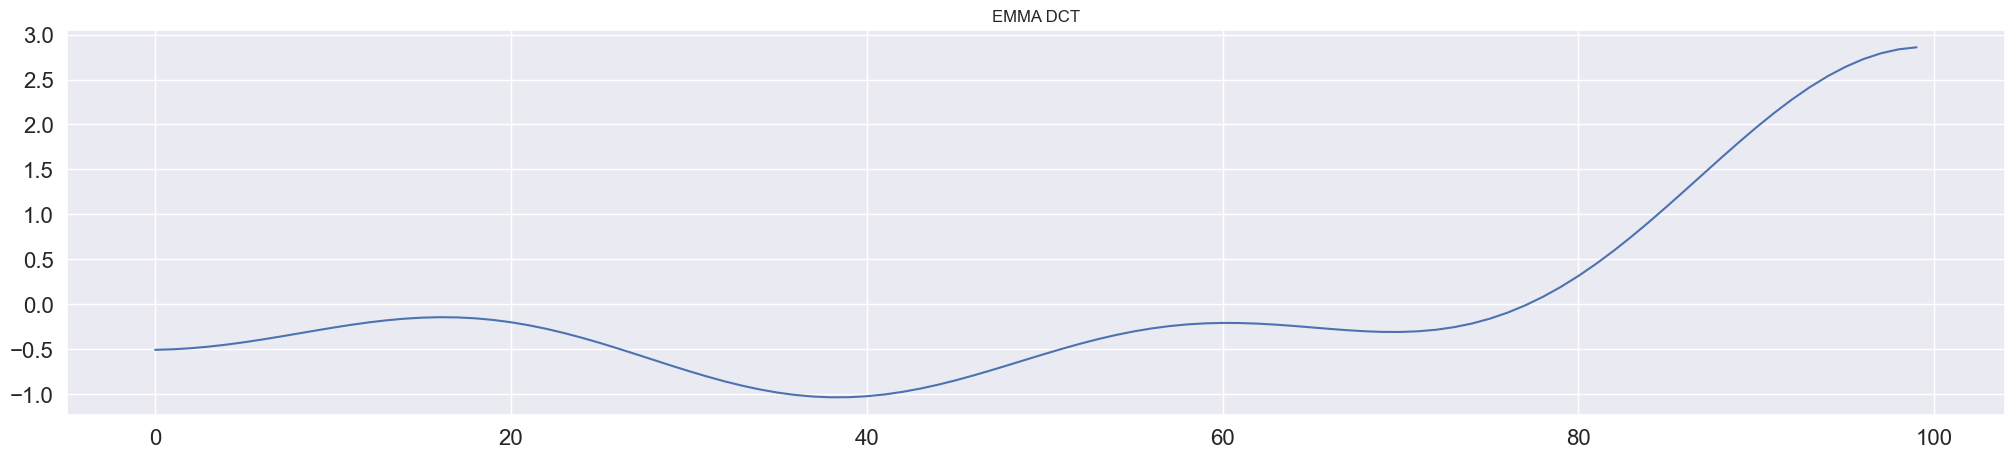

In [78]:
plot_sent(158)

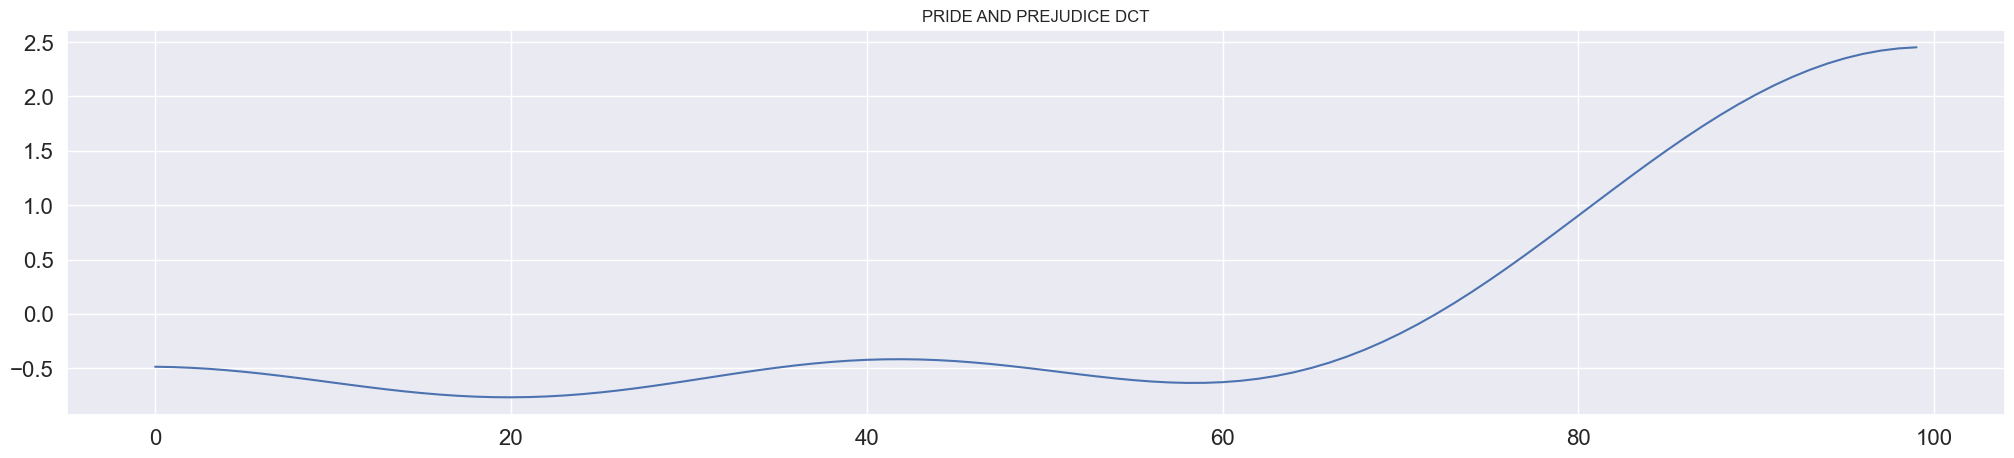

In [79]:
plot_sent(1342)